In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import os

In [47]:
# -------------------------------
# 1️⃣ 读取谱线列表文件
# -------------------------------
def read_line_list(filepath):
    lines, freqs, mark07, mark09, mark10 = [], [], [], [], []
    with open(filepath, 'r') as f:
        
        # 跳过第一行
        next(f)
        
        for line in f:
            if line.strip() == '':
                continue
            parts = line.split()
            if len(parts) < 2:
                continue
            lines.append(parts[0])
            freqs.append(float(parts[1]))
            
            if len(parts) >= 5:
                mark07.append(int(parts[2]))
                mark09.append(int(parts[3]))
                mark10.append(int(parts[4]))
            else:
                mark07.append(0)
                mark09.append(0)
                mark10.append(0)
                
    return lines, np.array(freqs), mark07, mark09, mark10

# -------------------------------
# 2️⃣ 多文件光谱数据集类
# -------------------------------
class MultiSourceSpectrumDataset(Dataset):
    def __init__(self, data_dir, line_file, window=0.03, target_len=128,
                 normalize=True, velocity_dict=None):
        """
        初始化多源光谱数据集
        
        参数:
        - data_dir: 包含所有光谱文件的目录
        - line_file: 谱线列表文件路径
        - window: 提取窗口大小
        - target_len: 目标子光谱长度
        - normalize: 是否归一化
        - velocity_dict: 字典，键为源名称，值为速度修正值 (km/s)
        """
        self.line_names, self.line_rest, self.mark07, self.mark09, self.mark10 = read_line_list(line_file)
        self.line_name_to_index = {name: i for i, name in enumerate(self.line_names)}
        
        self.marks_dict = {
        'Lh07': self.mark07,
        'Lh09': self.mark09,
        'Lh10': self.mark10,}
            
        self.c = 299792458  # m/s
        self.window = window
        self.target_len = target_len
        self.normalize = normalize
        
        # 如果没有提供速度字典，创建空字典
        if velocity_dict is None:
            velocity_dict = {}
        
        # 存储所有样本和对应的信息
        self.samples = []        # 光谱数据
        self.full_names = []     # 完整标识符，格式: "源-频率窗口-谱线名称"
        self.source_info = []    # 源信息，格式: (源名称, 频率窗口, 谱线名称)
        self.scales=[]           # 初始化缩放因子列表
        self.marks=[]            # 谱线标签（该频率是否存在信号）
        
        # 查找所有光谱文件
        # 假设文件命名格式: "spectrum.源名称.频率窗口.commonbeam.1arcsec.dat"
        pattern = os.path.join(data_dir, "spectrum.*.spw*.commonbeam.1arcsec.dat")
        spectrum_files = glob.glob(pattern)
        
        if not spectrum_files:
            print(f"警告: 在目录 {data_dir} 中没有找到匹配的光谱文件")
            return
        
        print(f"找到 {len(spectrum_files)} 个光谱文件")
        
        # 处理每个光谱文件
        for spectrum_file in spectrum_files:
            # 从文件名中提取源名称和频率窗口
            filename = os.path.basename(spectrum_file)
            parts = filename.split('.')
            if len(parts) < 3:
                print(f"跳过无法解析的文件: {filename}")
                continue
                
            source_name = parts[1]  # 例如 "Lh07"
            spw = parts[2]          # 例如 "spw0"
            
            print(f"处理文件: {filename}, 源: {source_name}, 频率窗口: {spw}")
            
            # 获取该源的速度修正值
            velocity = velocity_dict.get(source_name, None)
            
            # 处理单个光谱文件
            self._process_single_file(spectrum_file, source_name, spw, velocity)
            

        print(f"总共提取了 {len(self.samples)} 个谱线样本")

    
    def _process_single_file(self, spectrum_file, source_name, spw, velocity=None):
        """处理单个光谱文件"""
        try:
            i=0
            
            # 读取主光谱，跳过第一行
            data = np.loadtxt(spectrum_file, skiprows=1)
            freq_obs, flux = data[:, 0], data[:, 1]
            
            # 速度校正
            if velocity is not None:
                v = velocity * 1e3  # km/s → m/s
                freq = freq_obs / (1 - v / self.c)
                print(f"  [INFO] 应用速度修正: v = {velocity:.3f} km/s")
            else:
                freq = freq_obs
            
            # 对每条谱线提取子光谱
            for line_name, f_rest in zip(self.line_names, self.line_rest):
                mask = (freq > f_rest - self.window) & (freq < f_rest + self.window)
                if np.sum(mask) < 8:
                    continue  # 跳过数据点太少的谱线
                
                f_sub = freq[mask]
                flux_sub = flux[mask]
                i+=1
                print(i)
                print(line_name)
                plt.plot(f_sub,flux_sub)
                plt.show()
                
                # 插值到目标长度
                f_new = np.linspace(f_sub.min(), f_sub.max(), self.target_len)
                flux_new = np.interp(f_new, f_sub, flux_sub)
                
                # 归一化 (可选)
                if self.normalize:
                    #flux_new = (flux_new - np.mean(flux_new)) / (np.std(flux_new) + 1e-6)
                    scale = max(np.max(np.abs(flux_new)), 1e-6)
                    flux_norm = flux_new / scale
                else:
                    scale=1.0
                    flux_norm=flux_new

                
                # 创建完整标识符
                full_name = f"{source_name}-{spw}-{line_name}"
                
                # 保存样本和相关信息
                self.samples.append(torch.tensor(flux_norm, dtype=torch.float32).unsqueeze(0))
                self.full_names.append(full_name)
                self.source_info.append((source_name, spw, line_name))
                self.scales.append(scale)  # 保存了缩放因子

                
        except Exception as e:
            print(f"处理文件 {spectrum_file} 时出错: {e}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx], self.full_names[idx], self.scales[idx]
    
    def get_mark_by_line(self, idx=None, source_name=None, line_name=None):

    #获取特定谱线的标记（是否存在信号）

        # 如果提供了索引，获取源名称和谱线名称
        if idx is not None:
            if idx >= len(self.source_info):
                print(f"警告: 索引 {idx} 超出范围")
                return None
            source_name, _, line_name = self.source_info[idx]

        # 验证参数
        if source_name is None or line_name is None:
            print("错误: 必须提供 source_name 和 line_name，或者提供 idx")
            return None

        # 检查源是否有对应的标记数据
        if source_name not in self.marks_dict:  # 使用 marks_dict
            print(f"警告: 源 {source_name} 没有标记数据")
            return None

        # 获取谱线索引
        if line_name not in self.line_name_to_index:
            print(f"警告: 谱线 {line_name} 不存在")
            return None

        line_idx = self.line_name_to_index[line_name]

        # 获取标记值
        marks_list = self.marks_dict[source_name]  # 从 marks_dict 获取
        return marks_list[line_idx]
    
    def get_source_info(self, idx):
        """获取指定索引样本的源信息"""
        return self.source_info[idx]
    
    def get_samples_by_source(self, source_name):
        """获取特定源的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[0] == source_name]
    
    def get_samples_by_spw(self, spw):
        """获取特定频率窗口的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[1] == spw]
    
    def get_samples_by_line(self, line_name):
        """获取特定谱线的所有样本索引"""
        return [i for i, info in enumerate(self.source_info) if info[2] == line_name]


In [48]:
def collate_fn(batch):
    """处理批次数据，包括缩放因子"""
    xs = torch.stack([b[0] for b in batch])  # 光谱数据
    names = [b[1] for b in batch]            # 名称列表
    
    scales_list = [b[2] for b in batch]
    scales = torch.tensor(scales_list, dtype=torch.float32)
    scales = scales.view(-1, 1, 1)  # 重塑为 [batch_size, 1, 1]
    
    return xs, names, scales

找到 15 个光谱文件
处理文件: spectrum.Lh07.spw0.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw0
  [INFO] 应用速度修正: v = 239.516 km/s
1
34SO2


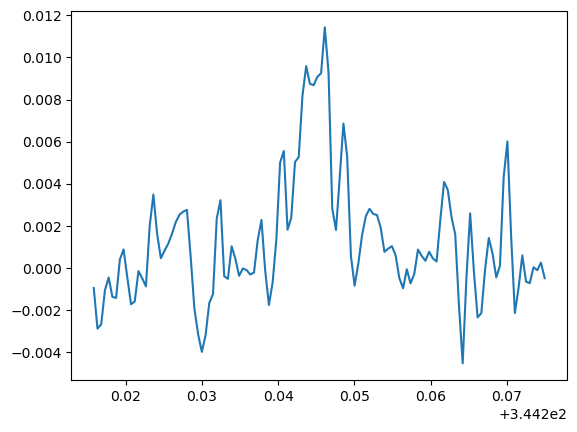

2
34SO2


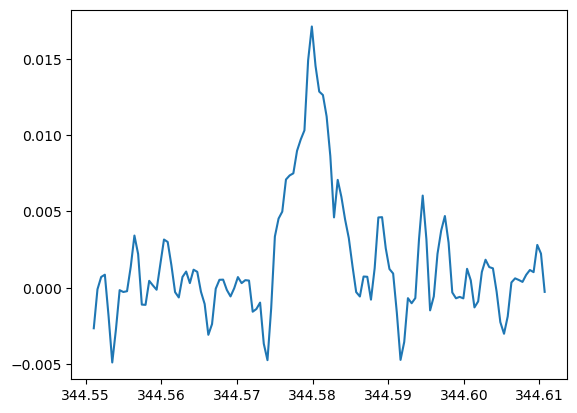

3
34SO2


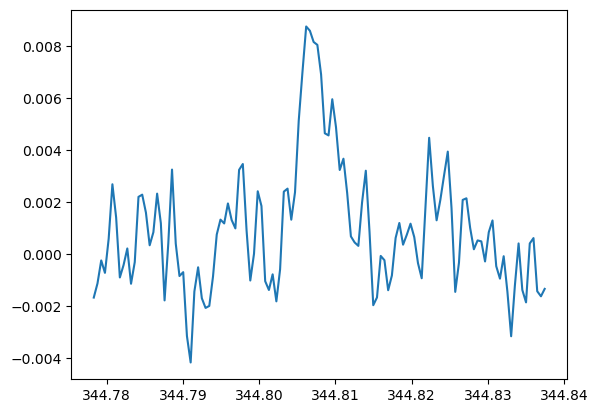

4
34SO2


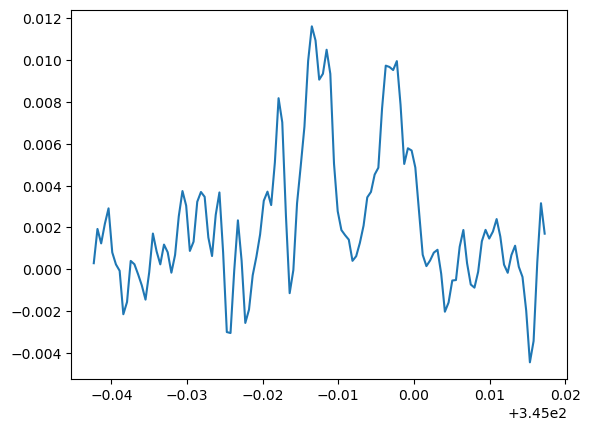

5
34SO2


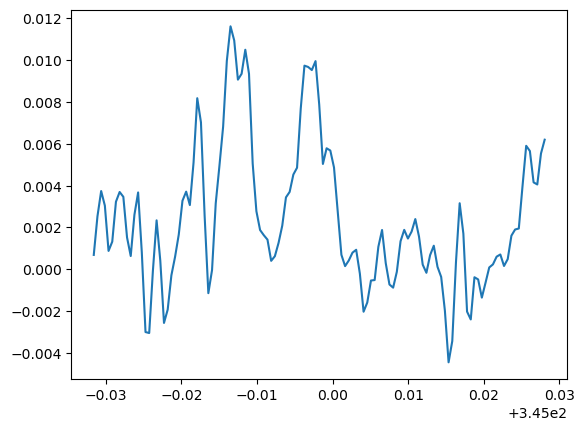

6
SO


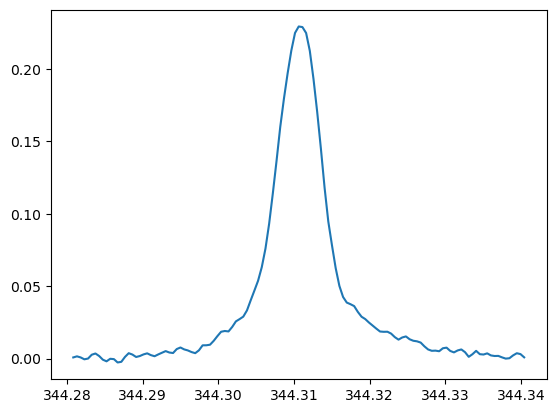

7
CH3OH


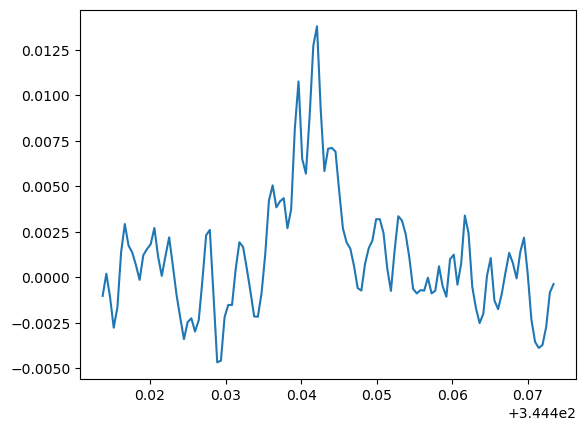

8
CH3OCH3


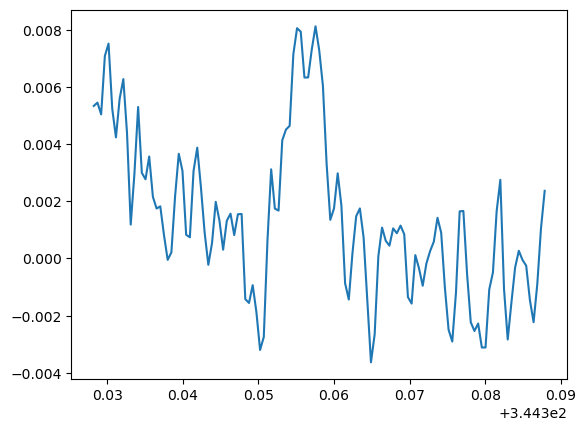

9
CH3OCH3


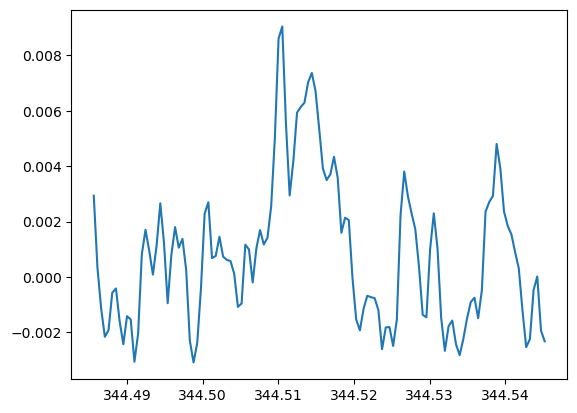

10
t-HCOOH


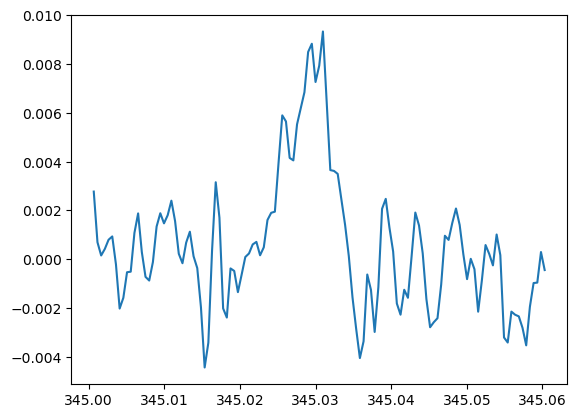

11
HC15N


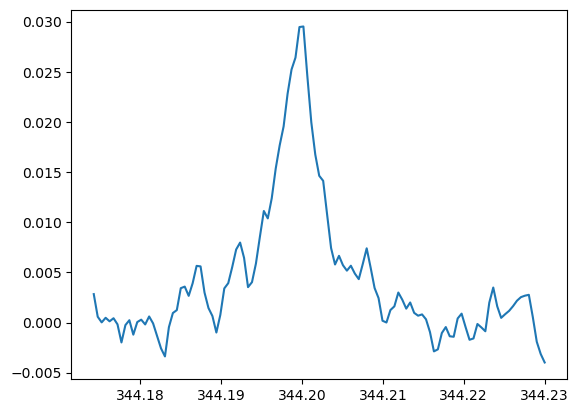

处理文件: spectrum.Lh07.spw1.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw1
  [INFO] 应用速度修正: v = 239.516 km/s
1
SO2


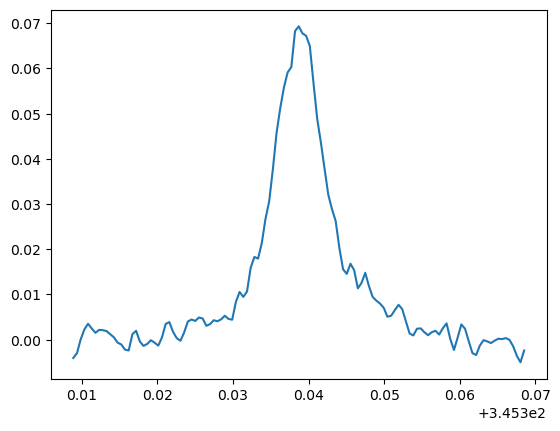

2
SO2


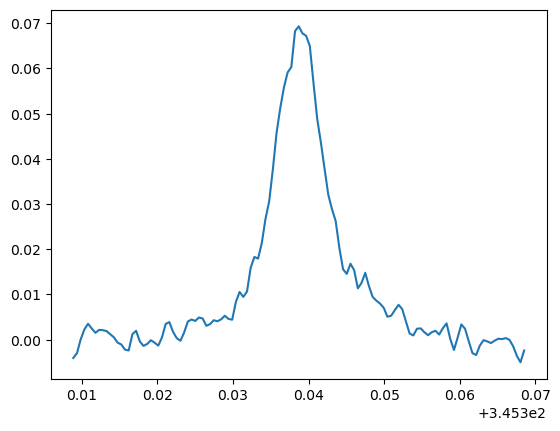

3
SO2


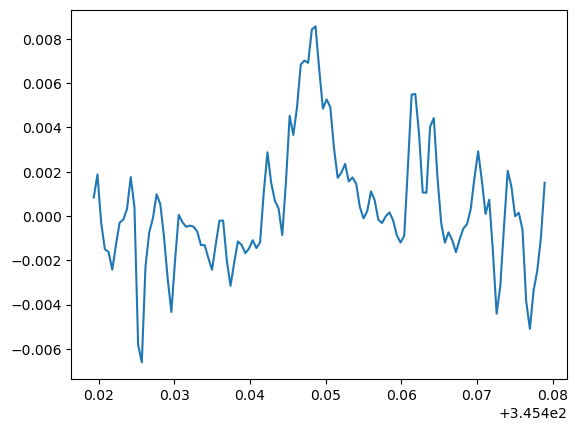

4
34SO2


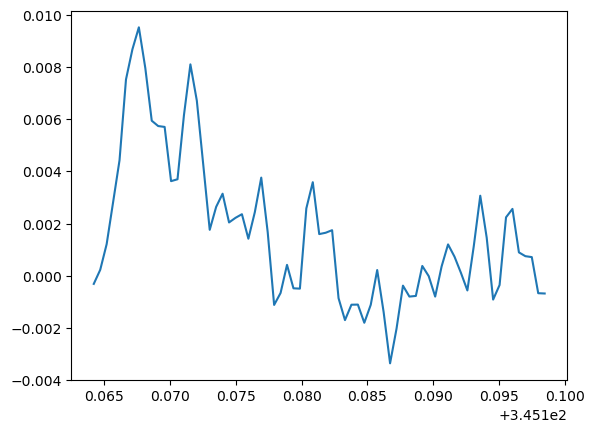

5
34SO2


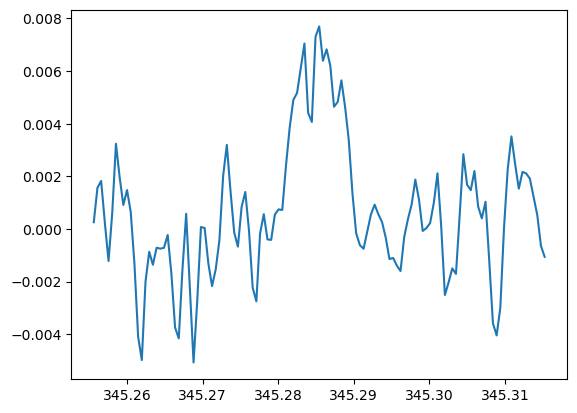

6
34SO2


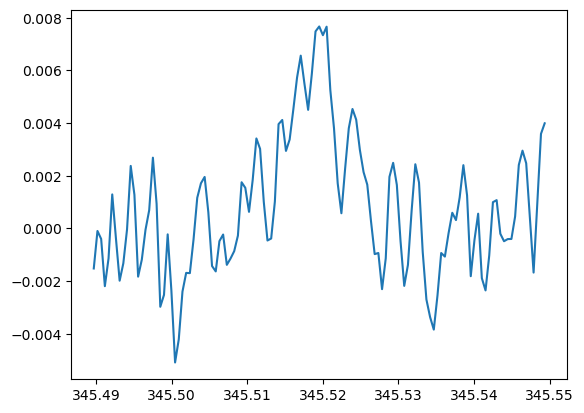

7
34SO2


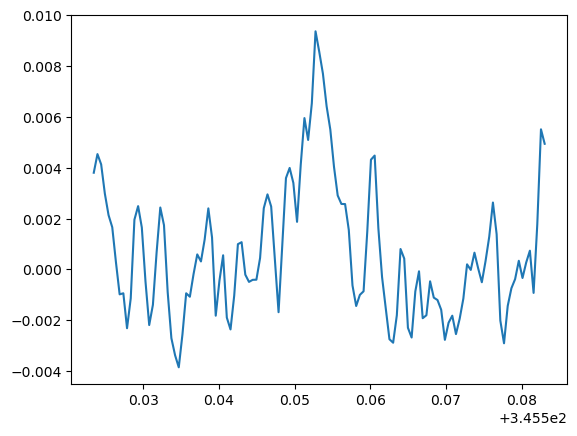

8
34SO2


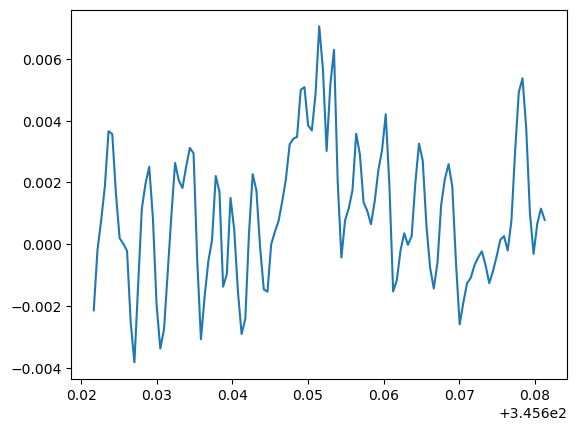

9
34SO2


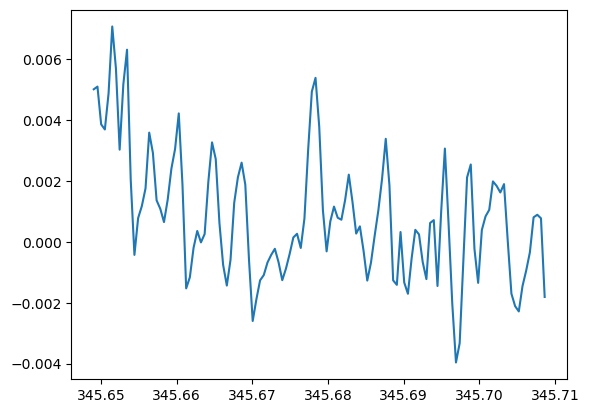

10
34SO2


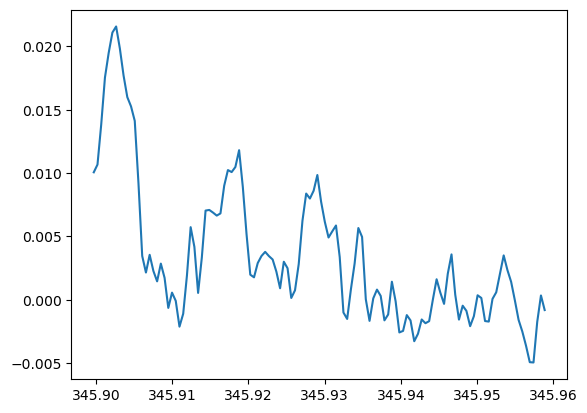

11
CO


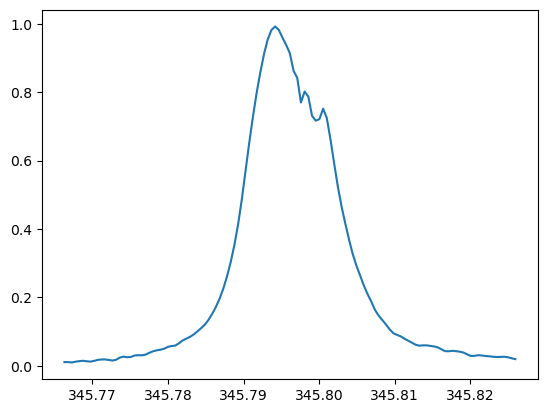

12
CH3OH


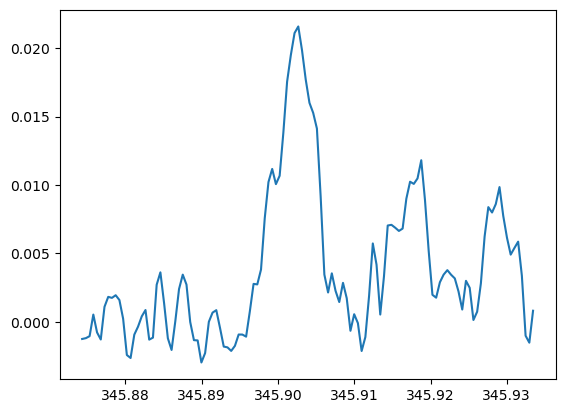

13
CH3OH


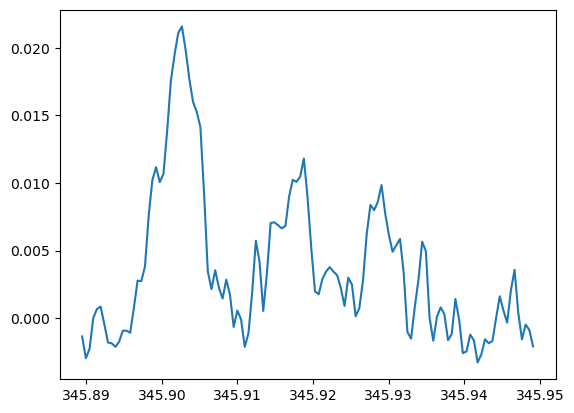

14
HC3N


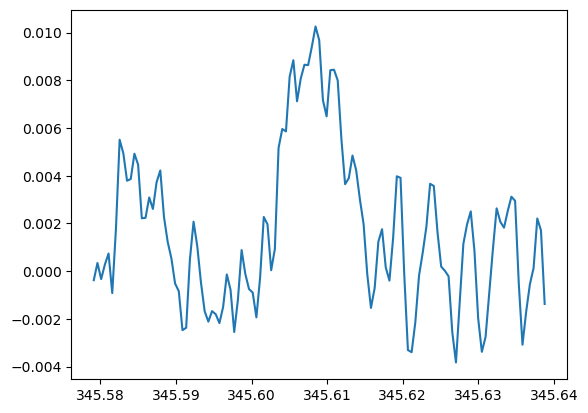

15
33SO2


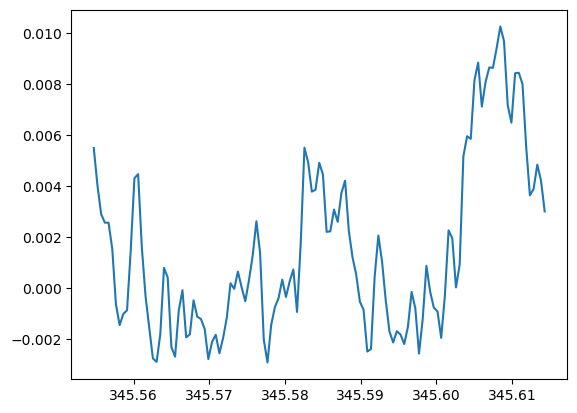

16
CH3OCHO???


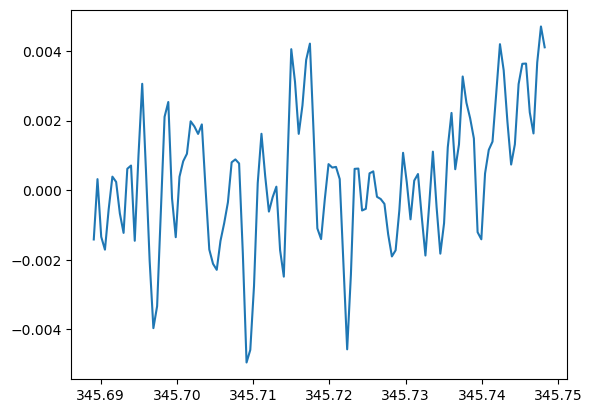

处理文件: spectrum.Lh07.spw2.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw2
  [INFO] 应用速度修正: v = 239.516 km/s
1
SO2


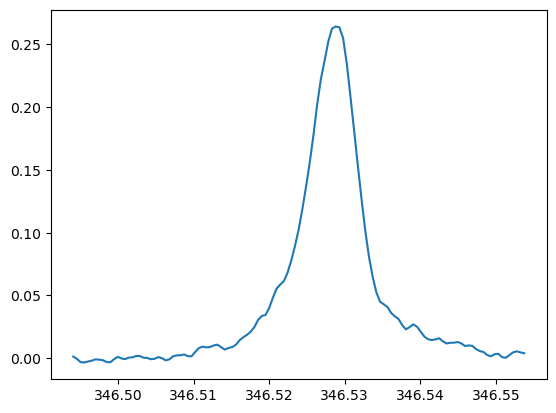

2
SO2


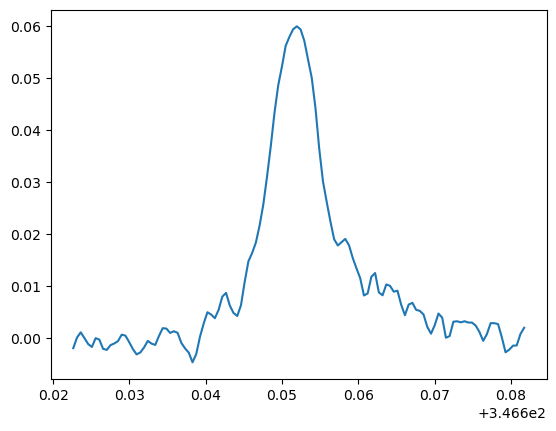

3
SO


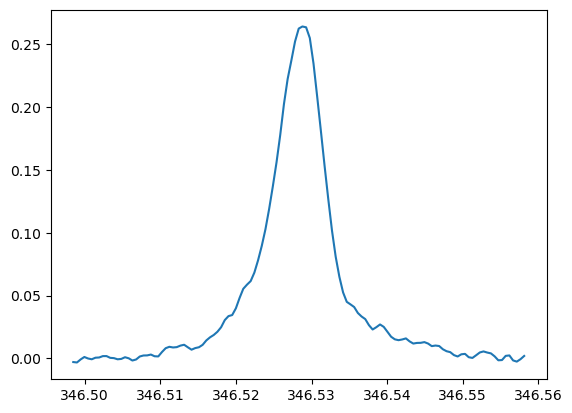

4
SO+


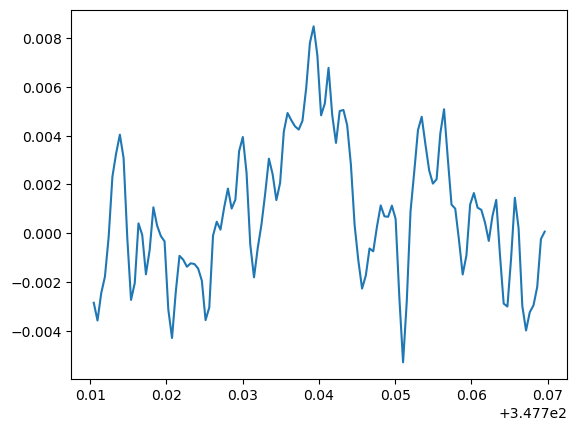

5
SiO


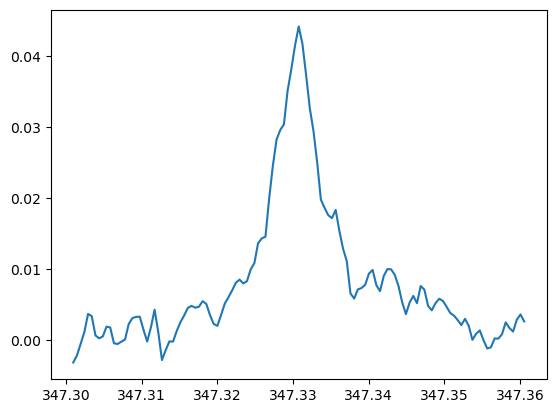

6
H13CO+


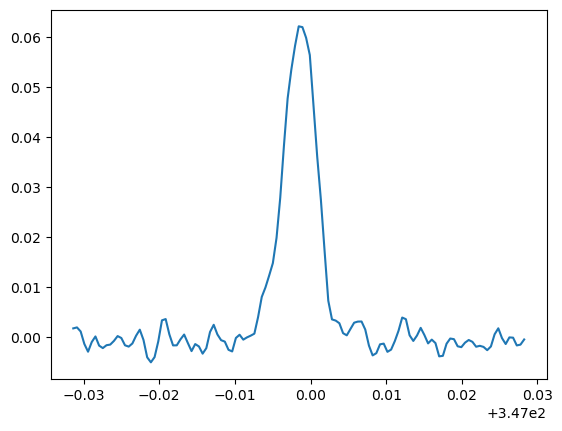

7
CH3OH


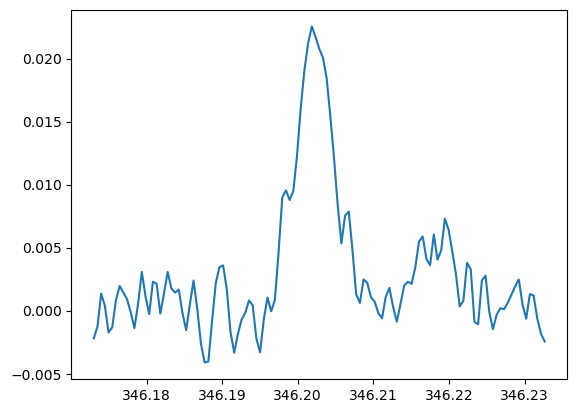

8
t-HCOOH


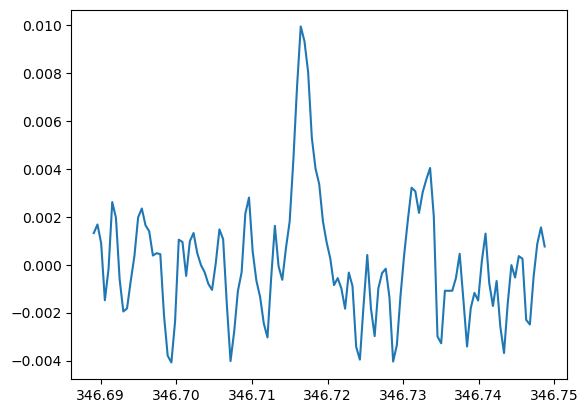

9
H37gamma


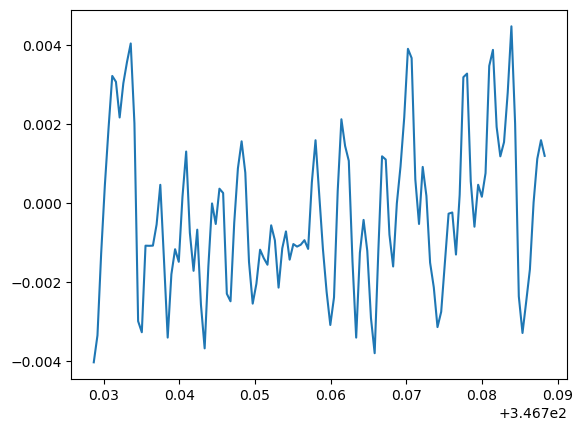

10
33SO2


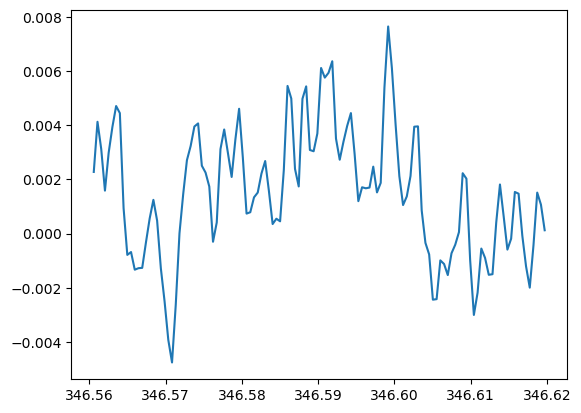

11
NS???


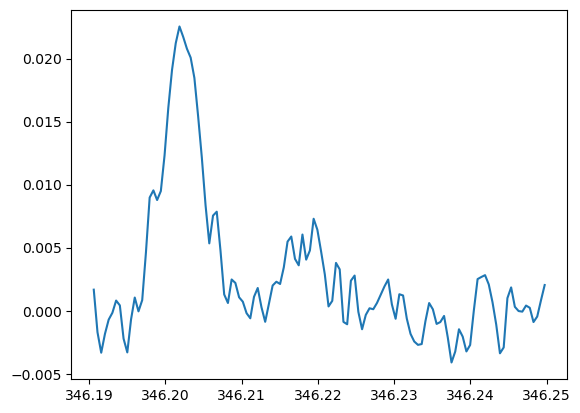

12
SO2_v2=1???


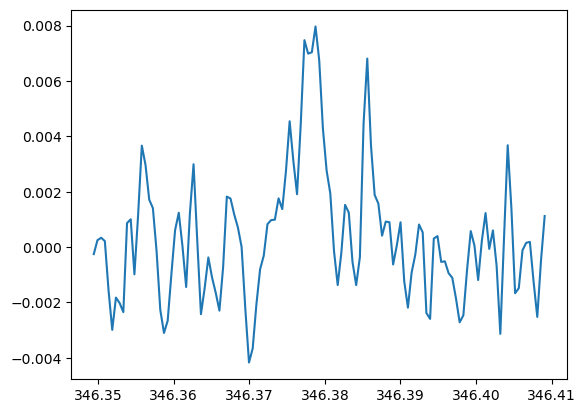

13
13CH3OH???


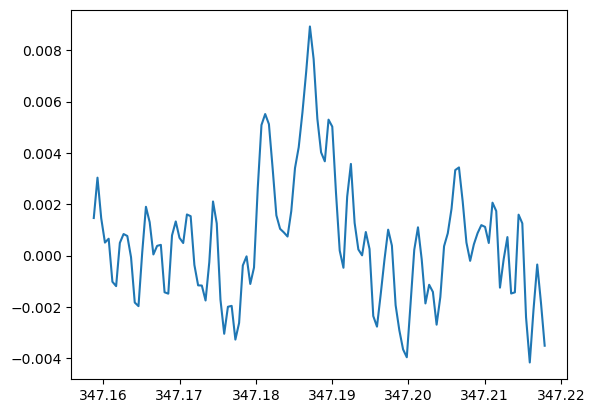

处理文件: spectrum.Lh07.spw3.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw3
  [INFO] 应用速度修正: v = 239.516 km/s
1
SO2


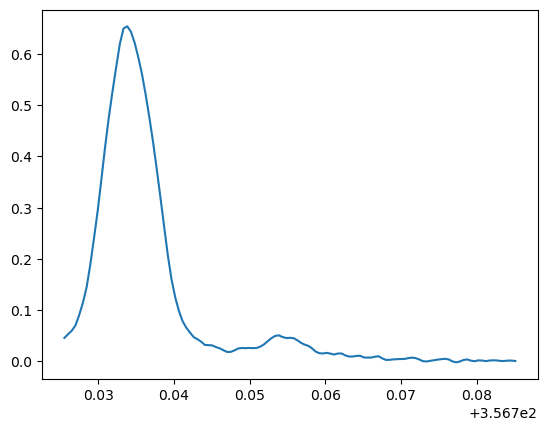

2
SO2


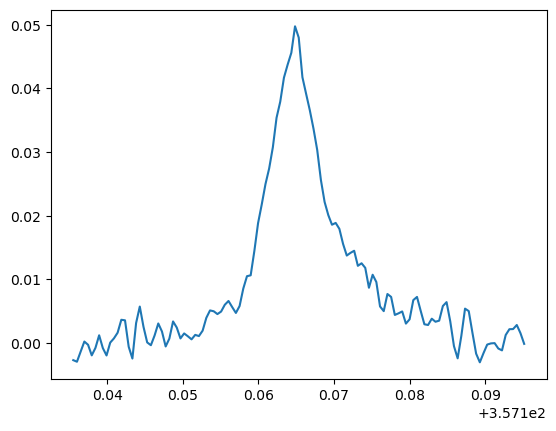

3
SO2


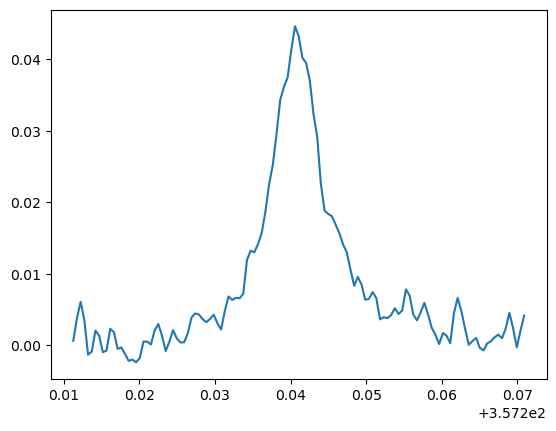

4
SO2


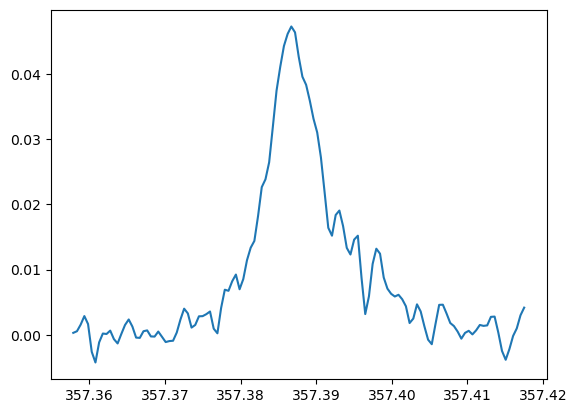

5
SO2


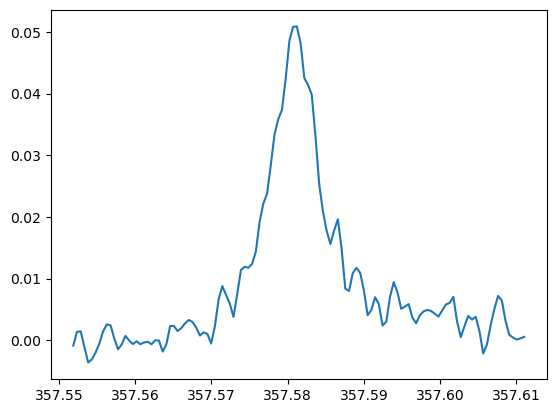

6
SO2


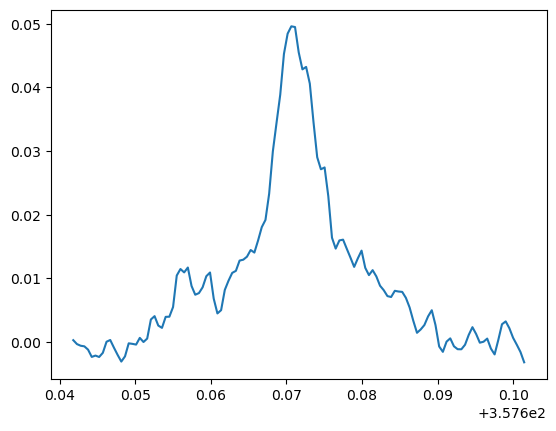

7
SO2


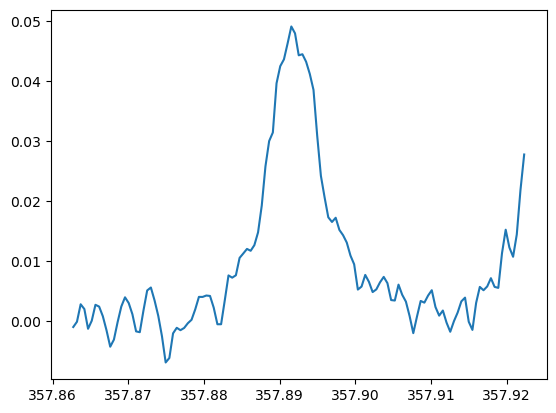

8
SO2


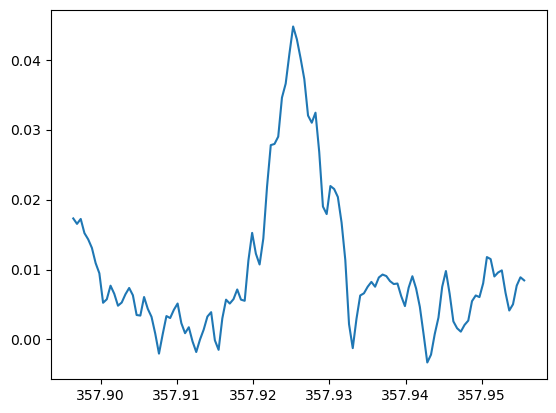

9
SO2


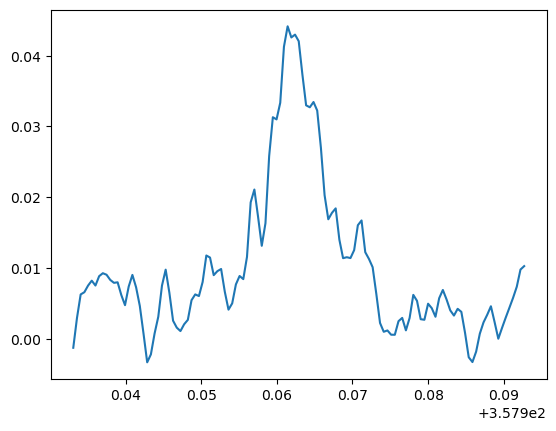

10
SO2


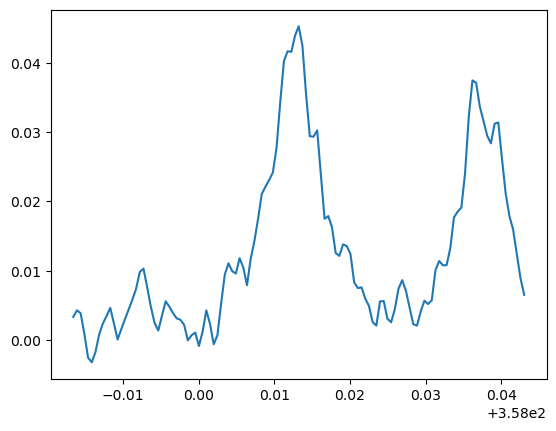

11
SO2


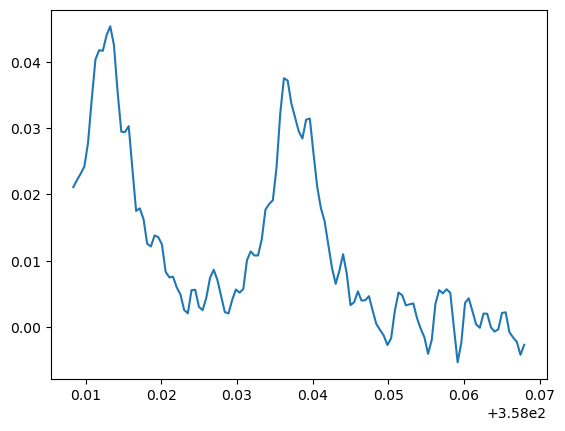

12
SO2


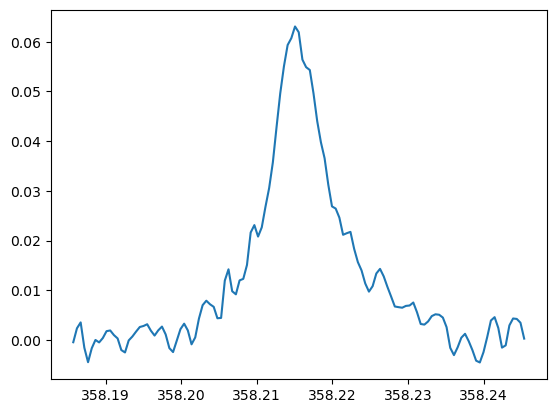

13
34SO2


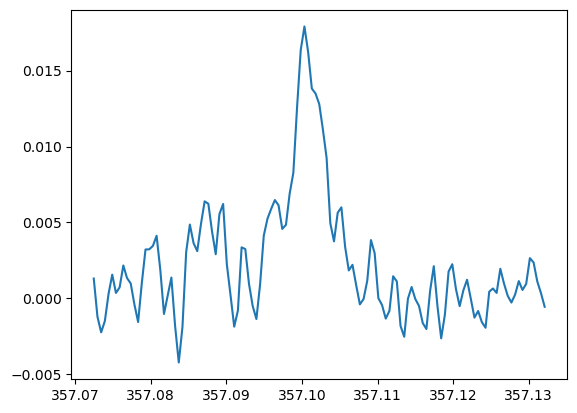

14
34SO2


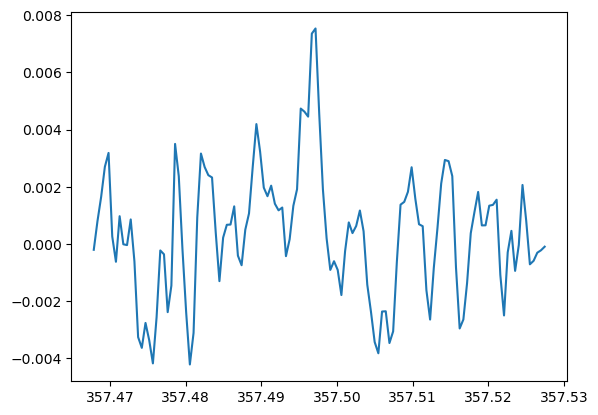

15
34SO2


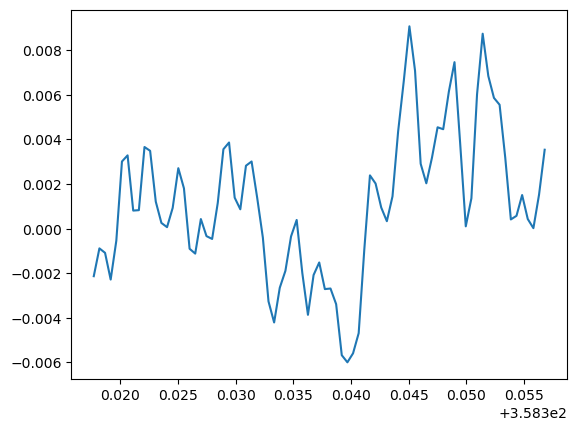

16
HCO+


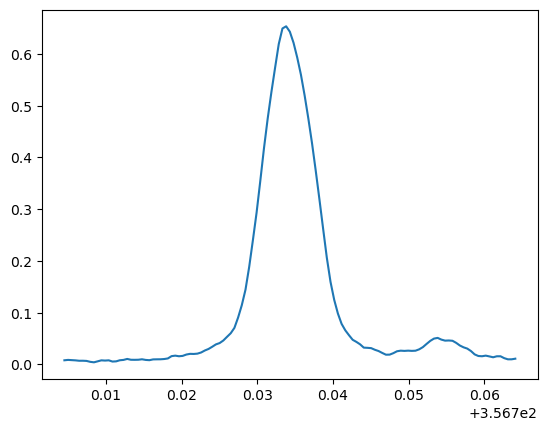

17
CH3OCH3


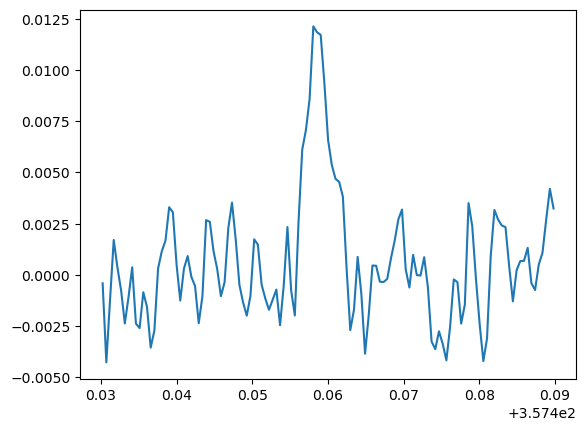

18
H40delta


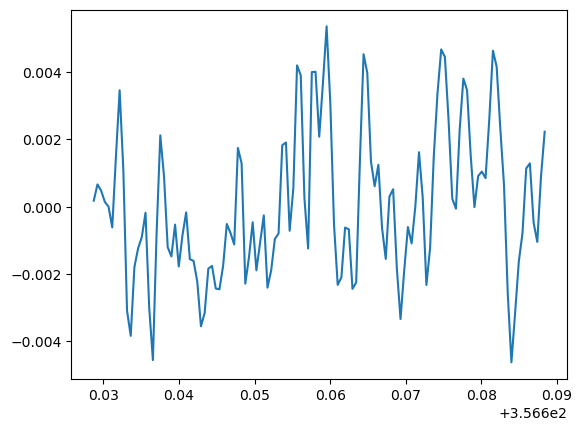

处理文件: spectrum.Lh07.spw4.commonbeam.1arcsec.dat, 源: Lh07, 频率窗口: spw4
  [INFO] 应用速度修正: v = 239.516 km/s
1
SO2


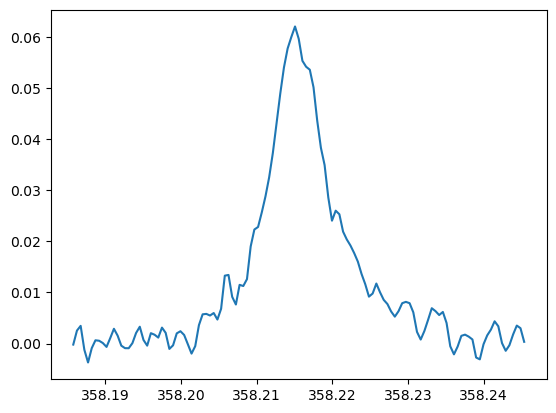

2
SO2


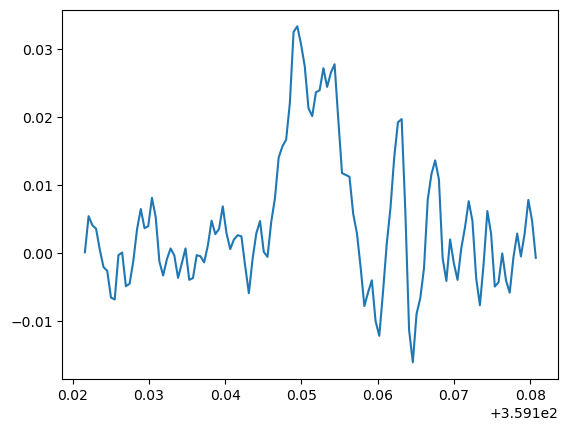

3
SO2


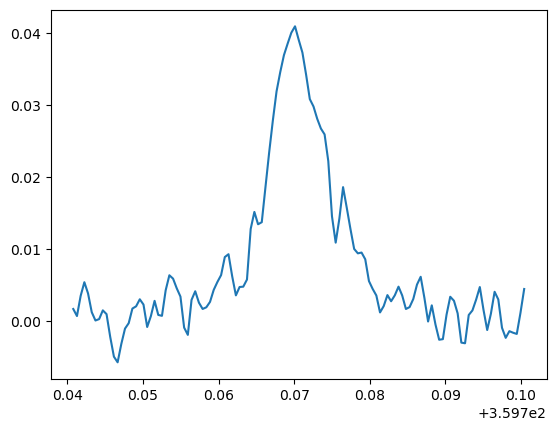

4
34SO2


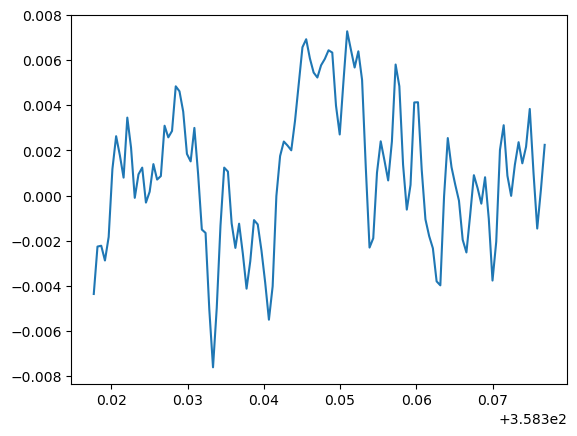

5
34SO2


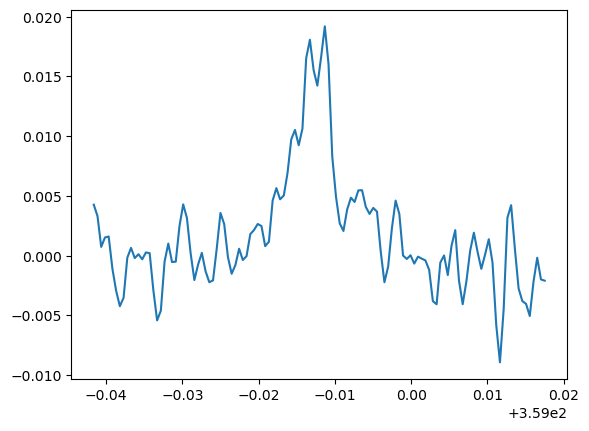

6
CH3OH


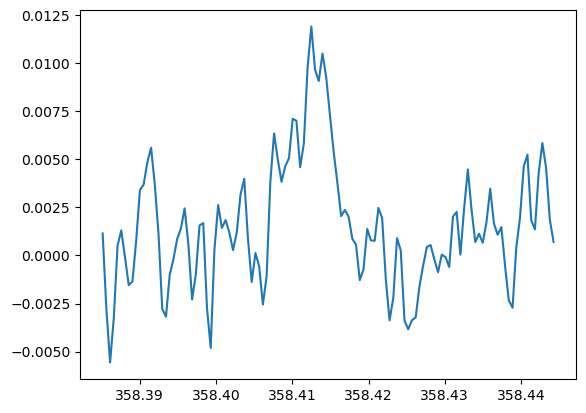

7
CH3OH


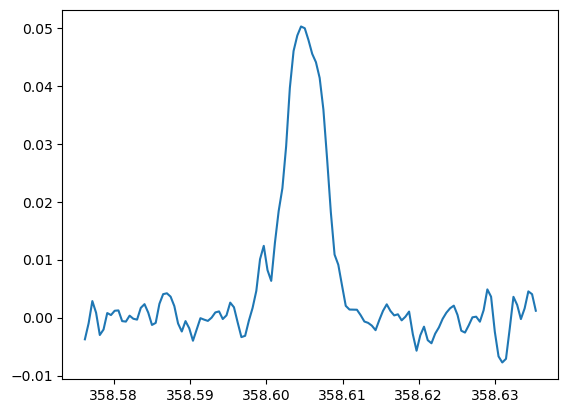

8
CH3OCH3


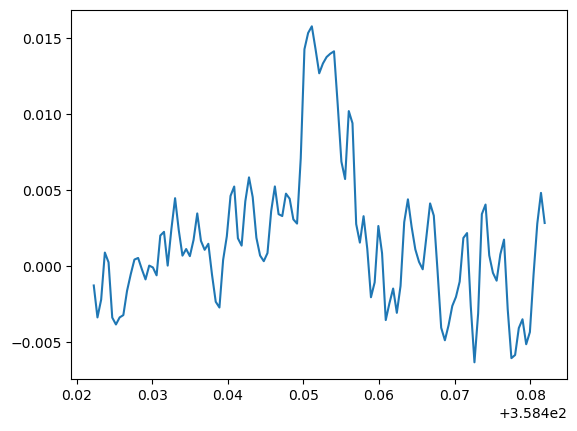

9
H45zeta


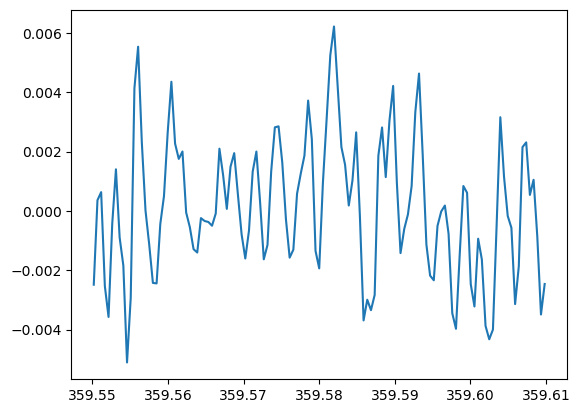

处理文件: spectrum.Lh09.spw0.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw0
  [INFO] 应用速度修正: v = 235.751 km/s
1
34SO2


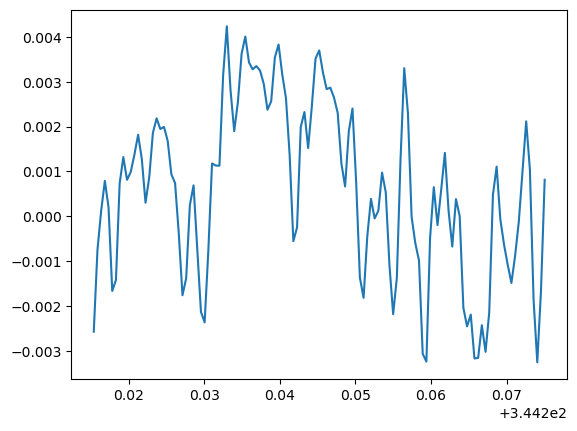

2
34SO2


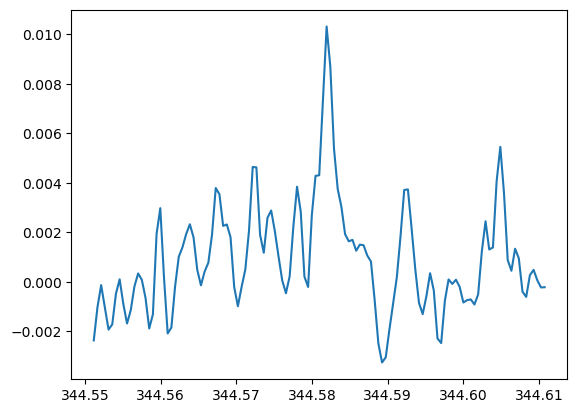

3
34SO2


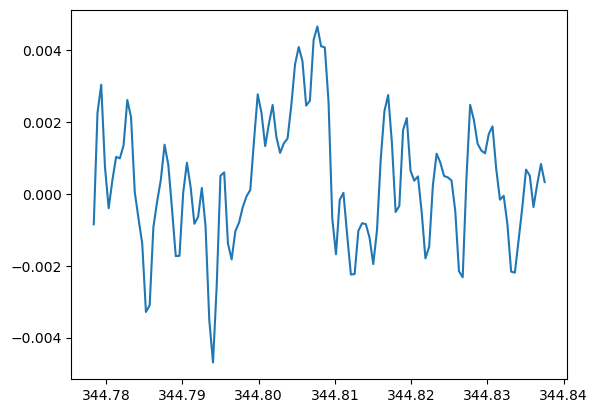

4
34SO2


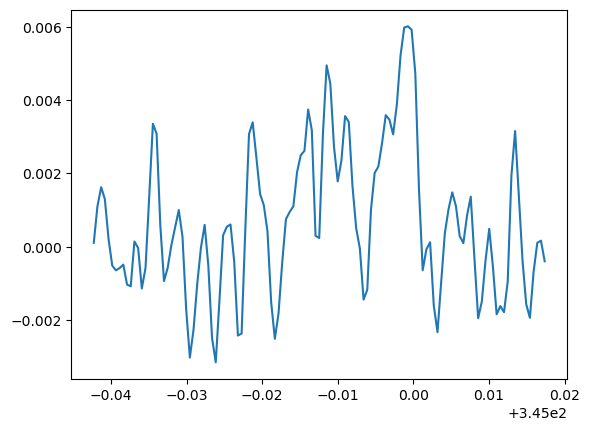

5
34SO2


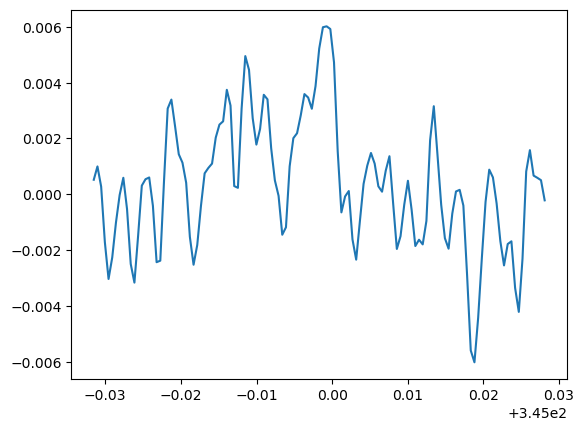

6
SO


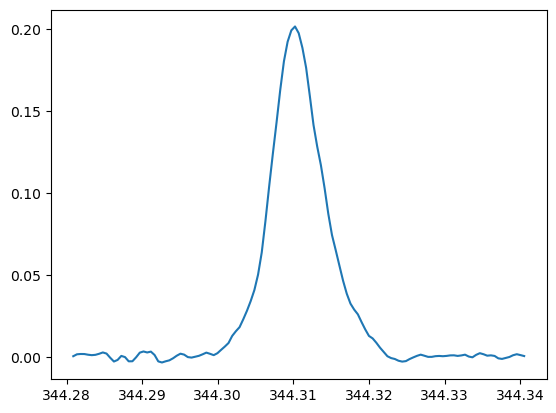

7
CH3OH


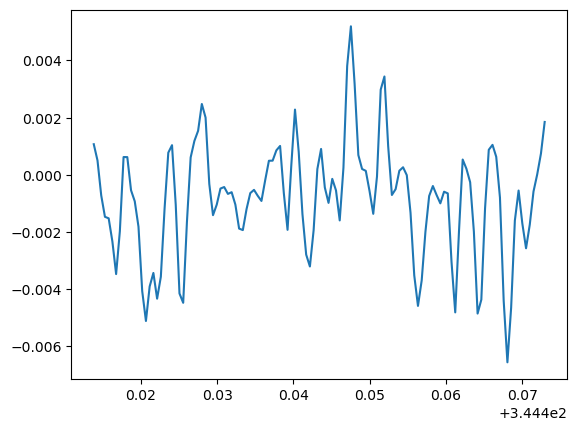

8
CH3OCH3


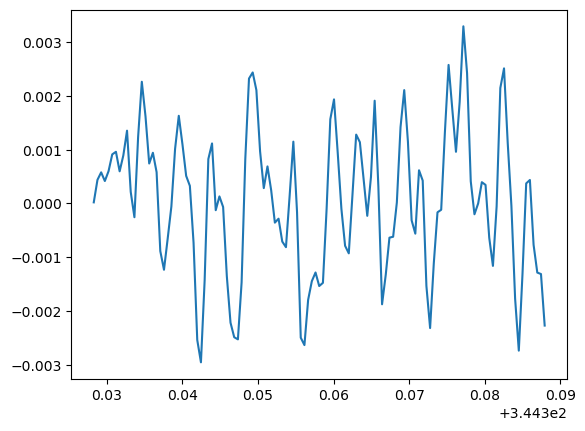

9
CH3OCH3


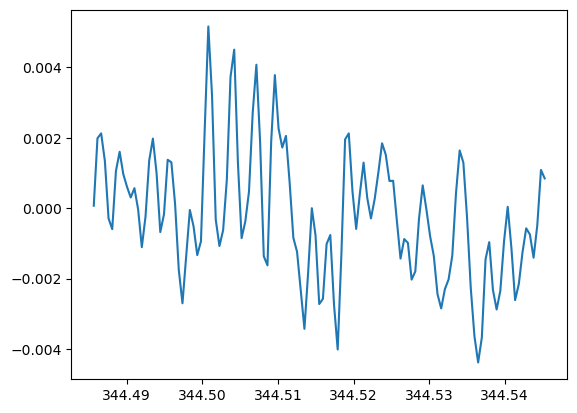

10
t-HCOOH


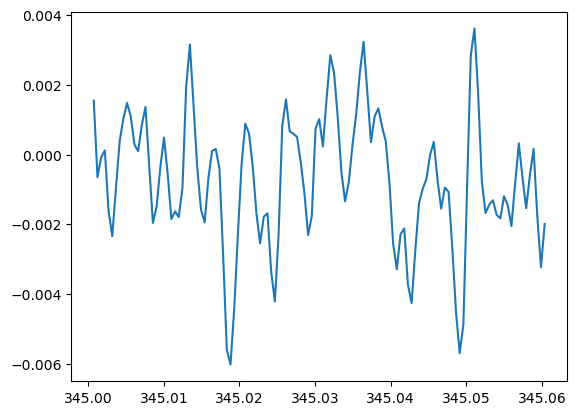

11
HC15N


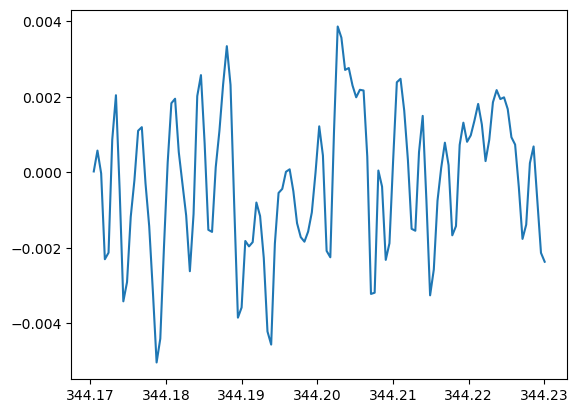

处理文件: spectrum.Lh09.spw1.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw1
  [INFO] 应用速度修正: v = 235.751 km/s
1
SO2


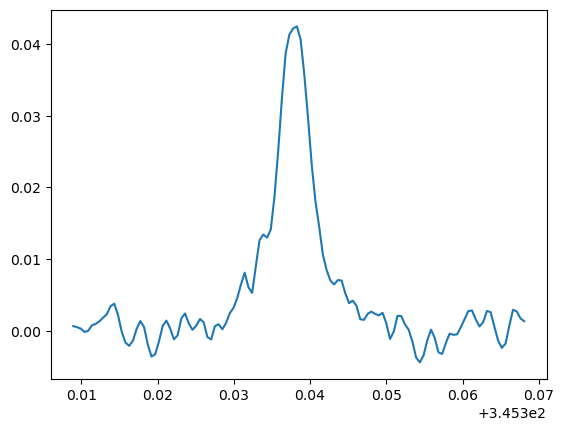

2
SO2


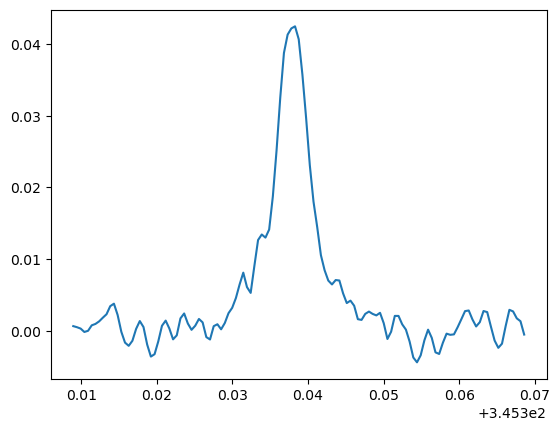

3
SO2


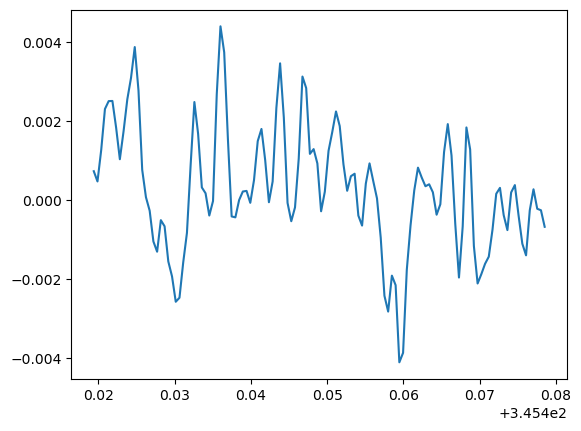

4
34SO2


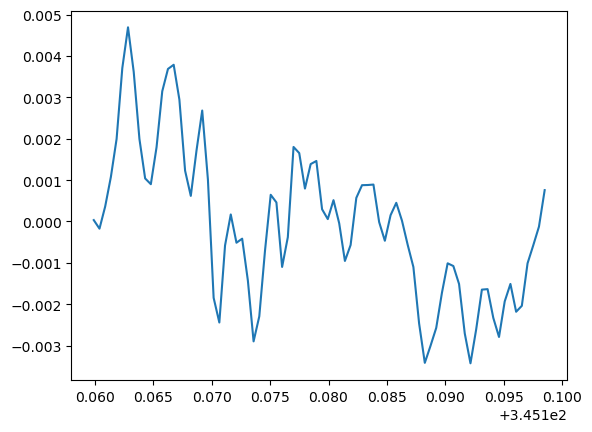

5
34SO2


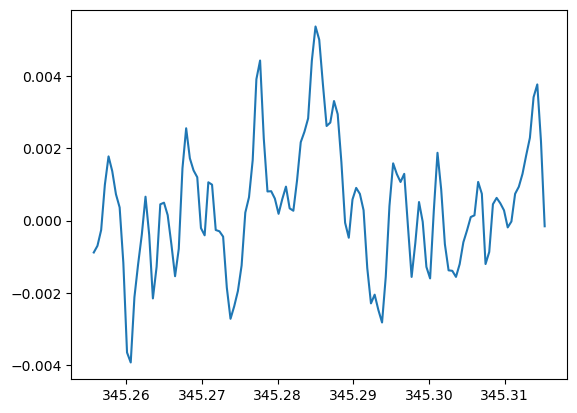

6
34SO2


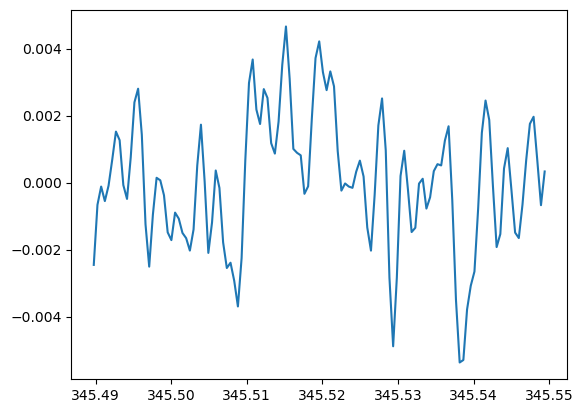

7
34SO2


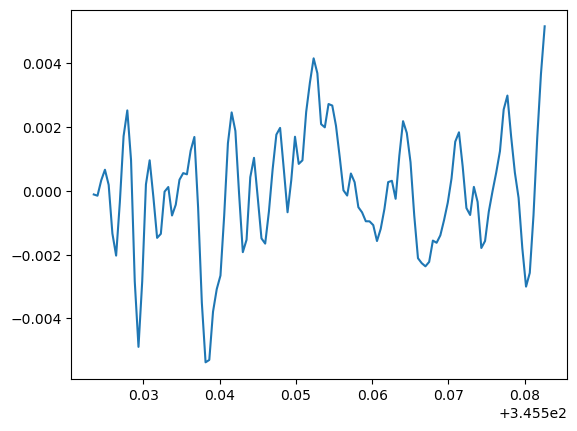

8
34SO2


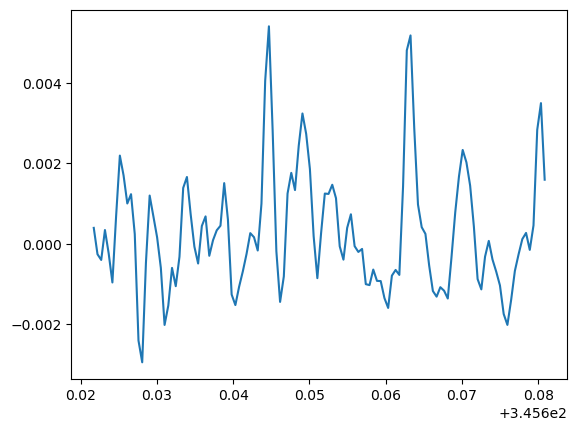

9
34SO2


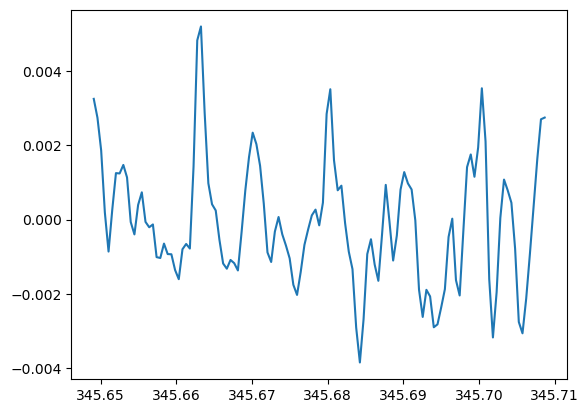

10
34SO2


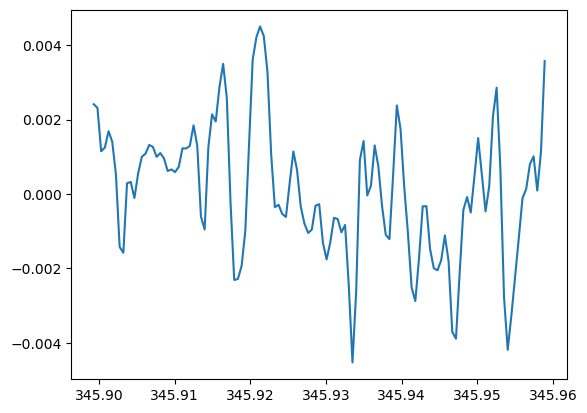

11
CO


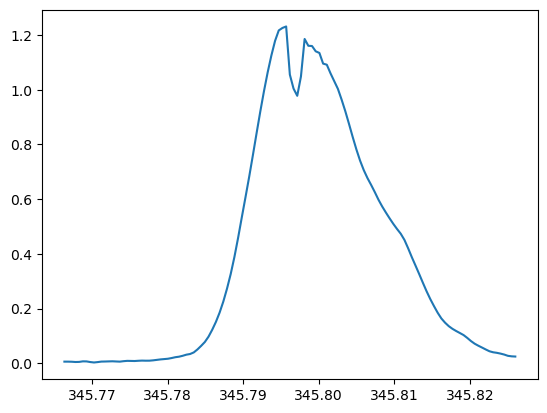

12
CH3OH


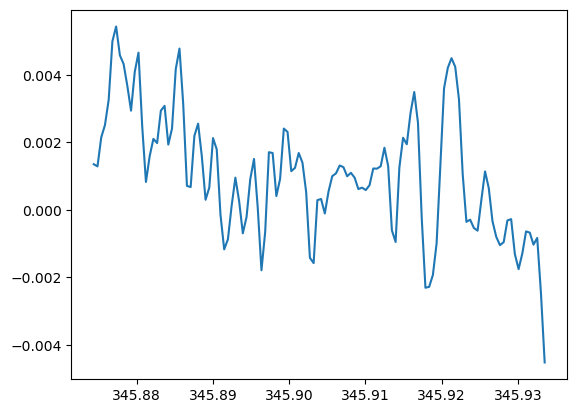

13
CH3OH


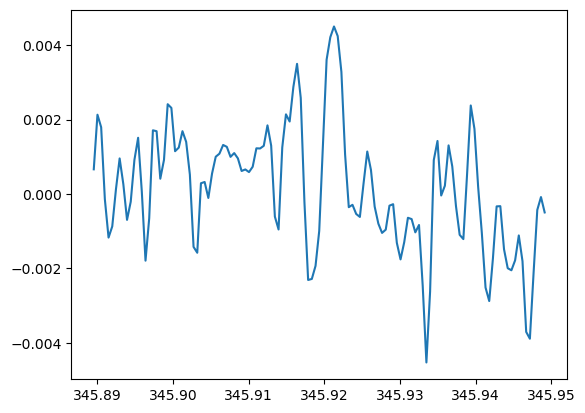

14
HC3N


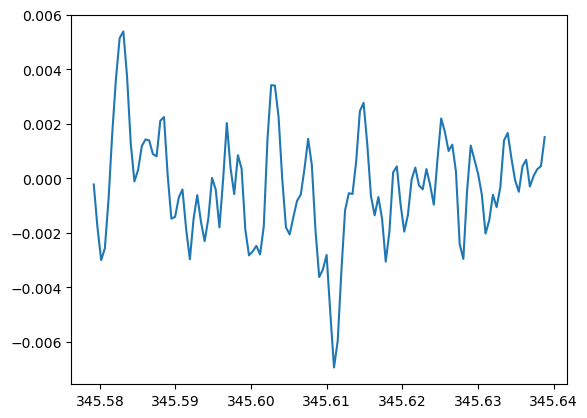

15
33SO2


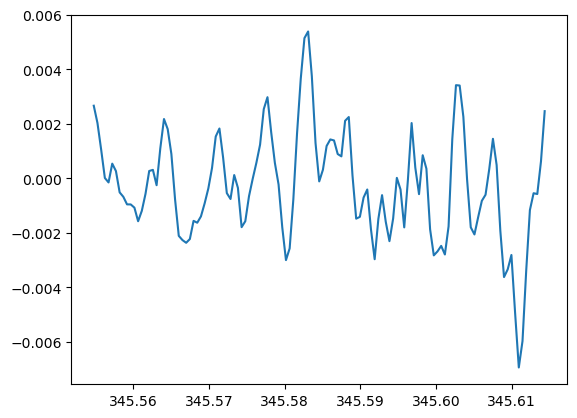

16
CH3OCHO???


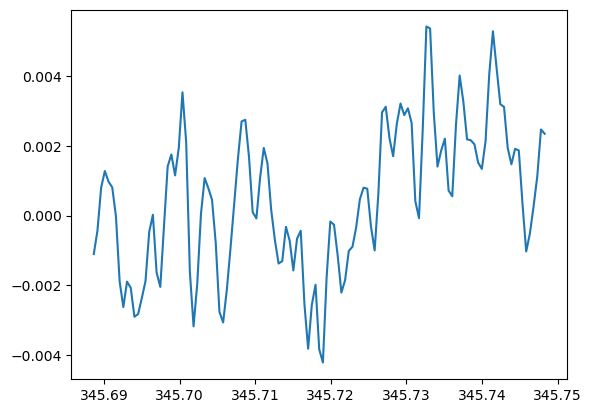

处理文件: spectrum.Lh09.spw2.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw2
  [INFO] 应用速度修正: v = 235.751 km/s
1
SO2


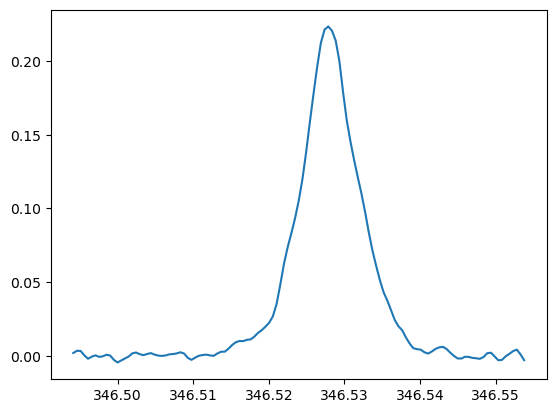

2
SO2


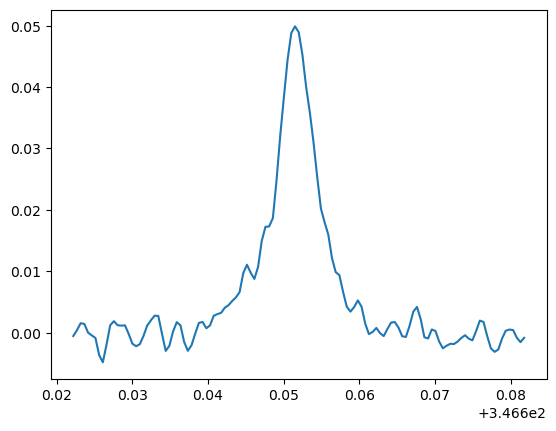

3
SO


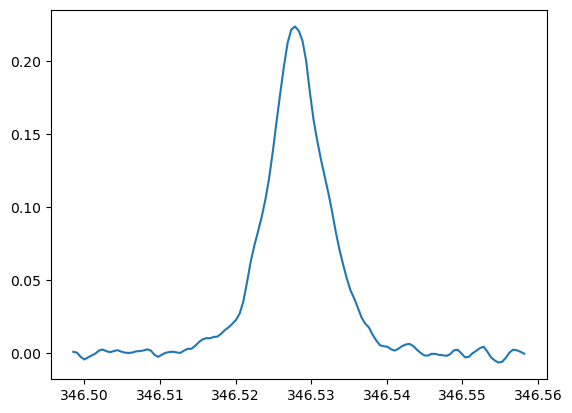

4
SO+


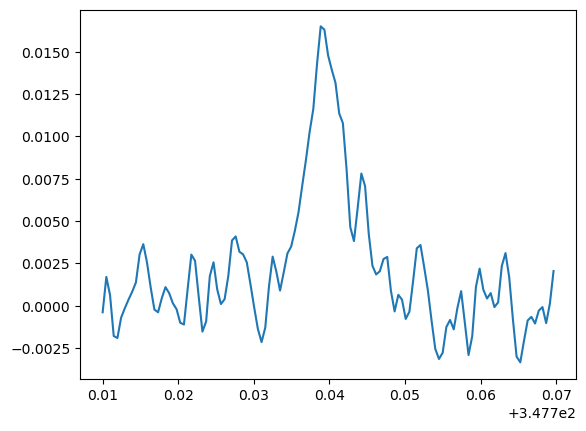

5
SiO


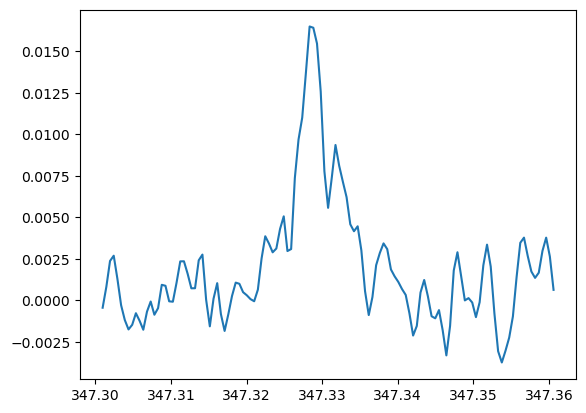

6
H13CO+


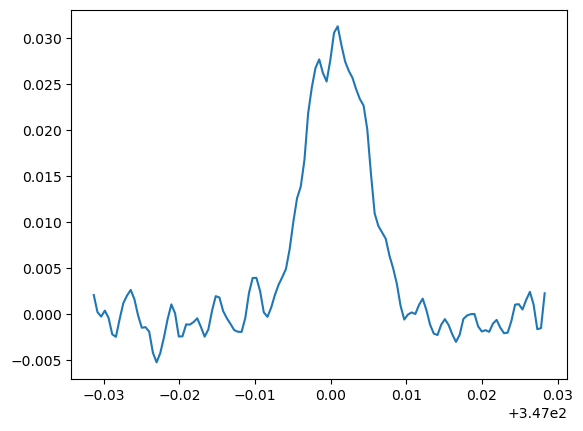

7
CH3OH


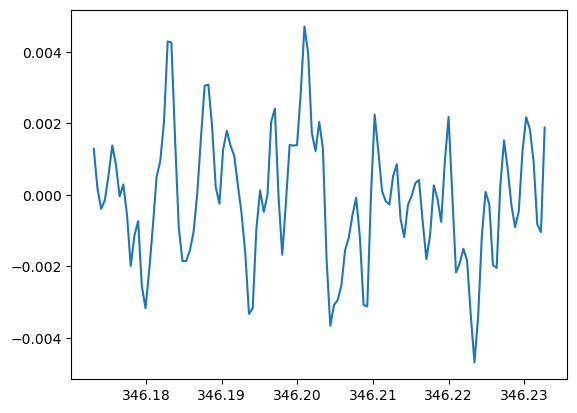

8
t-HCOOH


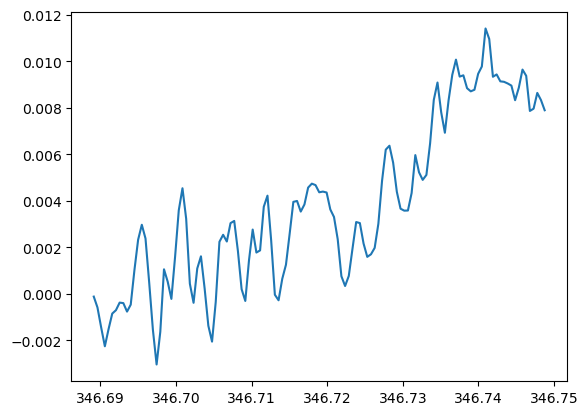

9
H37gamma


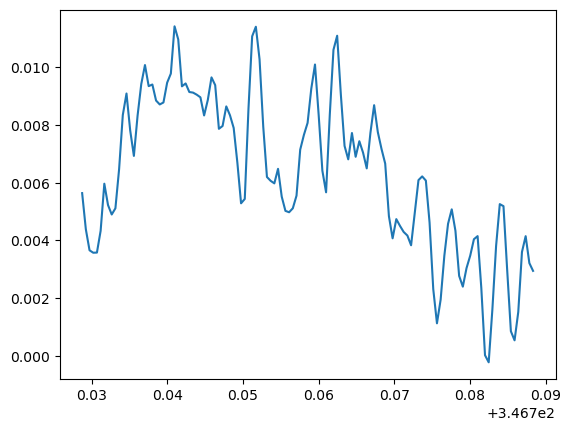

10
33SO2


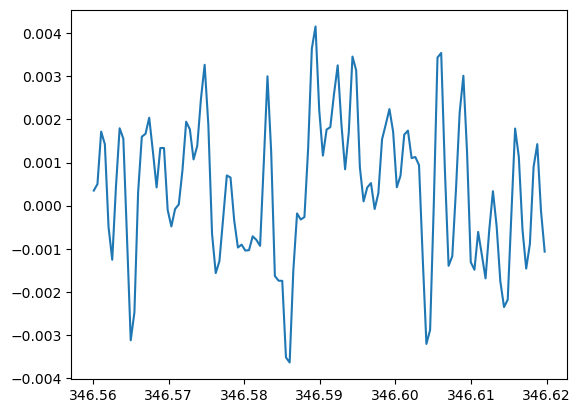

11
NS???


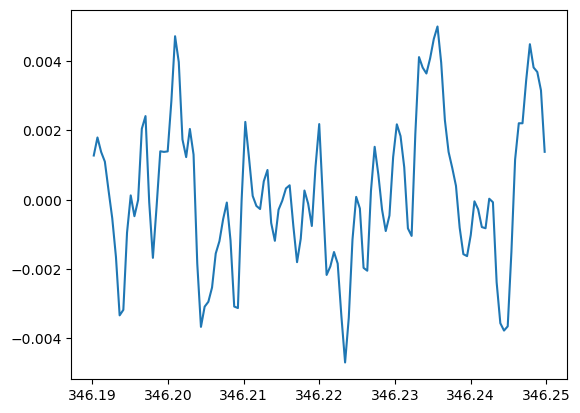

12
SO2_v2=1???


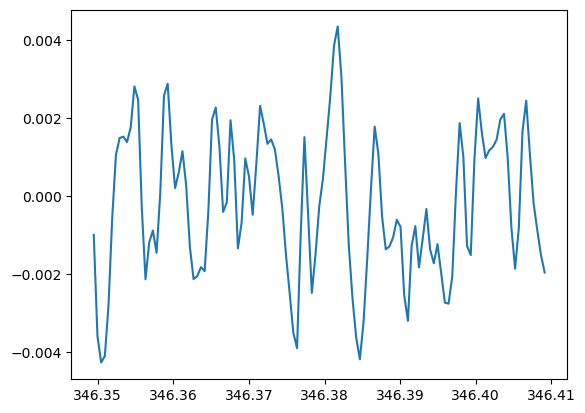

13
13CH3OH???


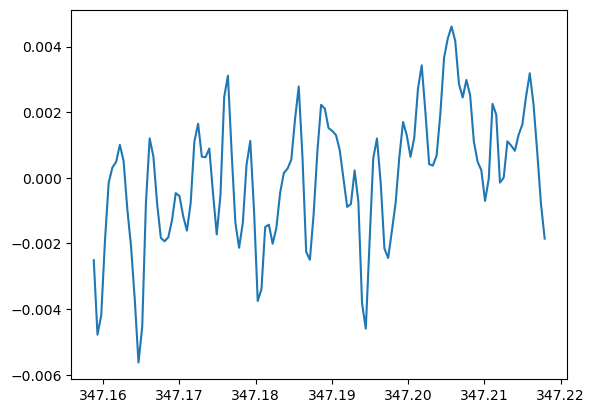

处理文件: spectrum.Lh09.spw3.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw3
  [INFO] 应用速度修正: v = 235.751 km/s
1
SO2


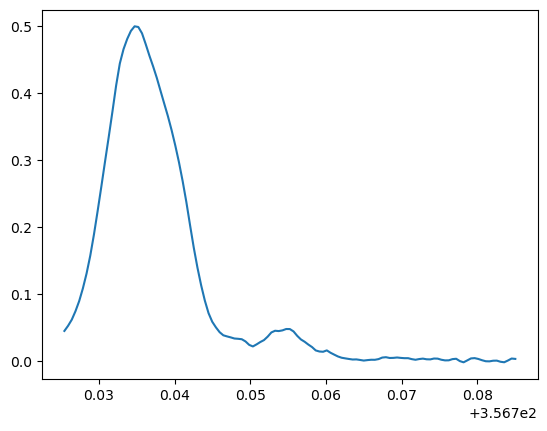

2
SO2


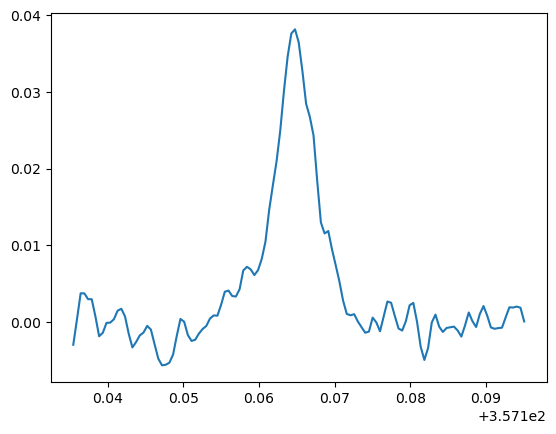

3
SO2


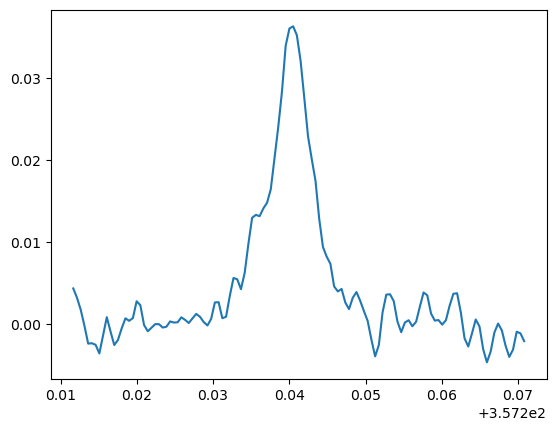

4
SO2


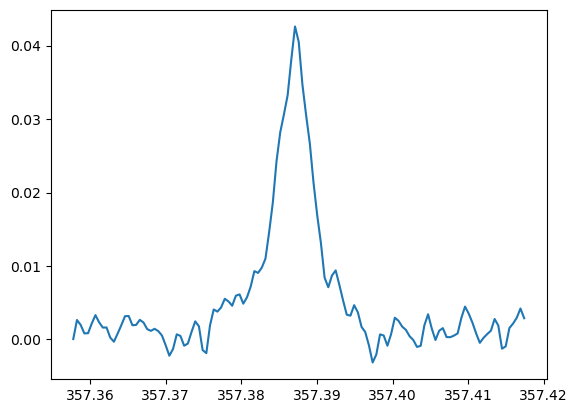

5
SO2


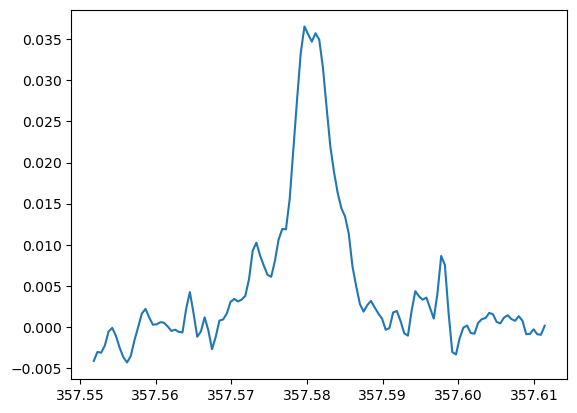

6
SO2


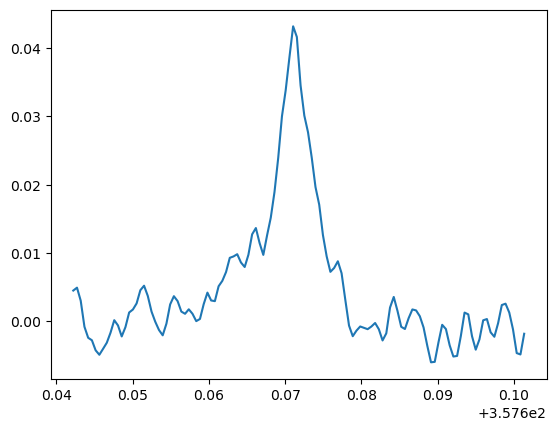

7
SO2


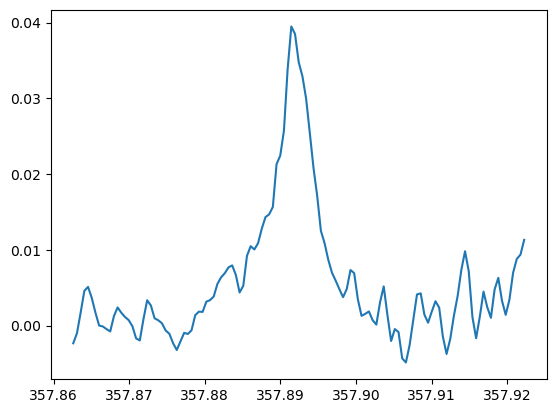

8
SO2


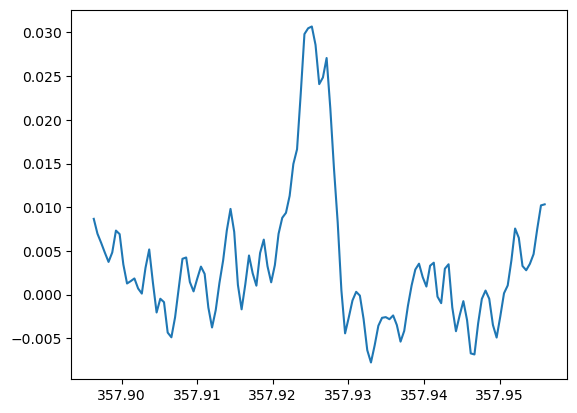

9
SO2


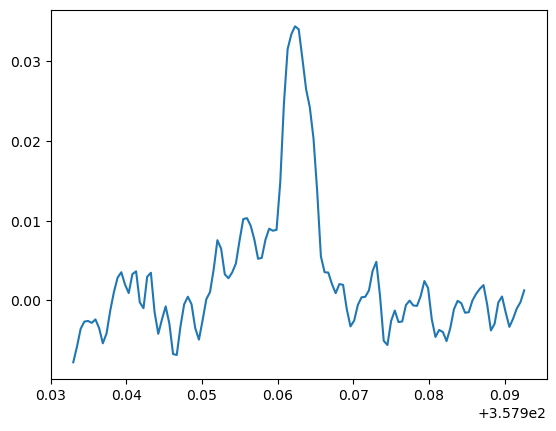

10
SO2


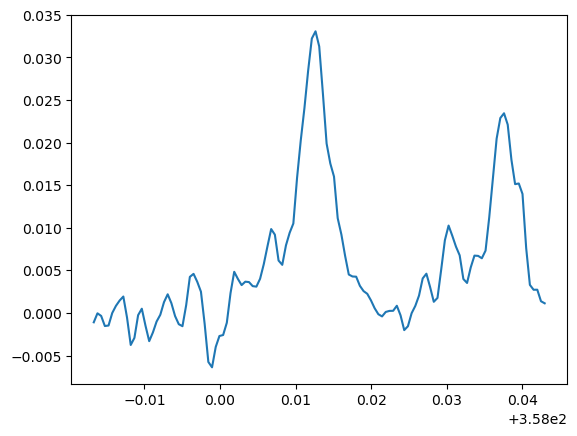

11
SO2


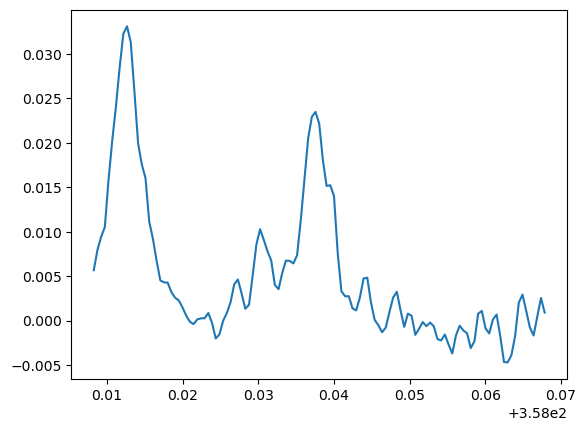

12
SO2


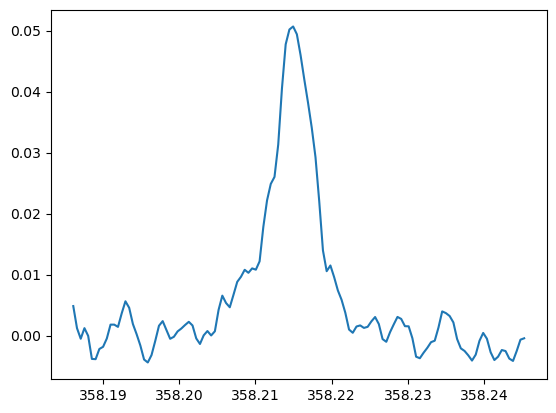

13
34SO2


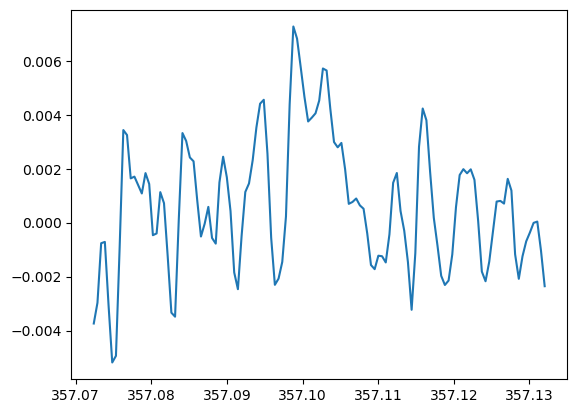

14
34SO2


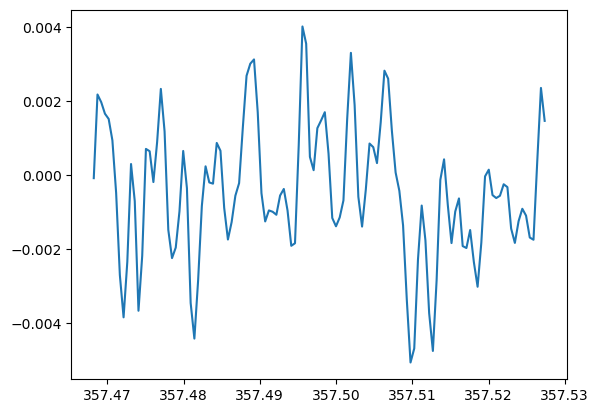

15
34SO2


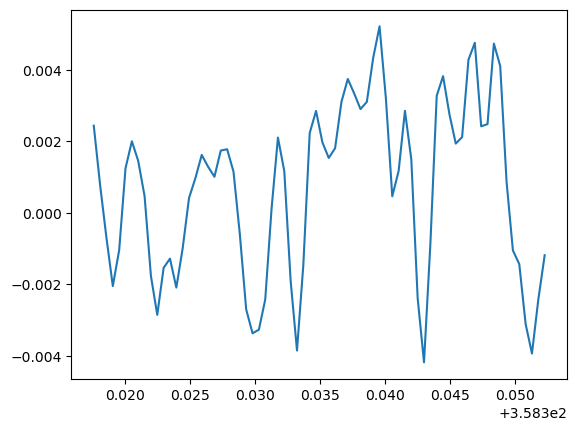

16
HCO+


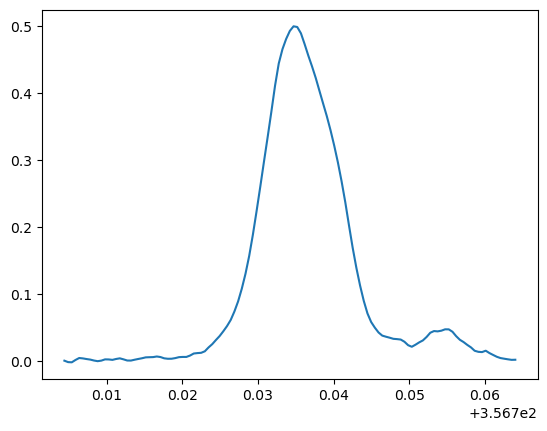

17
CH3OCH3


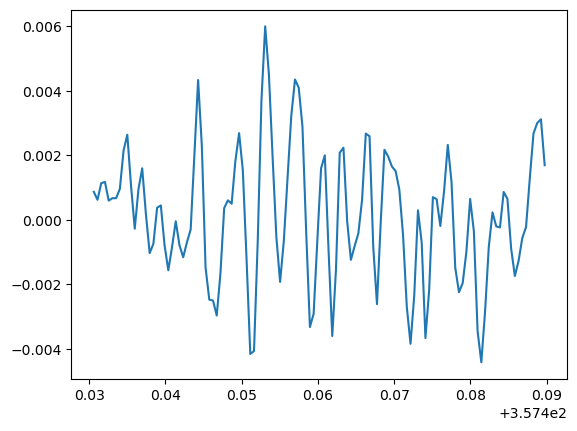

18
H40delta


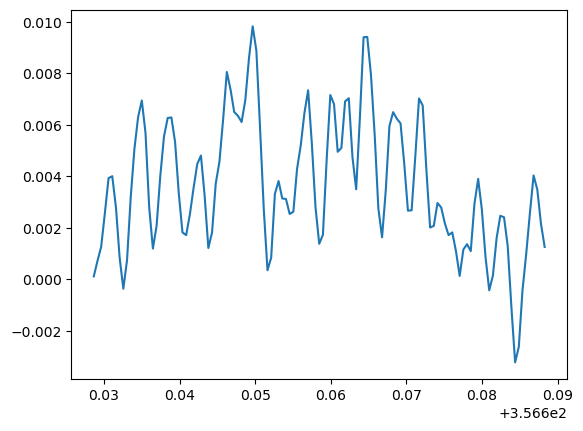

处理文件: spectrum.Lh09.spw4.commonbeam.1arcsec.dat, 源: Lh09, 频率窗口: spw4
  [INFO] 应用速度修正: v = 235.751 km/s
1
SO2


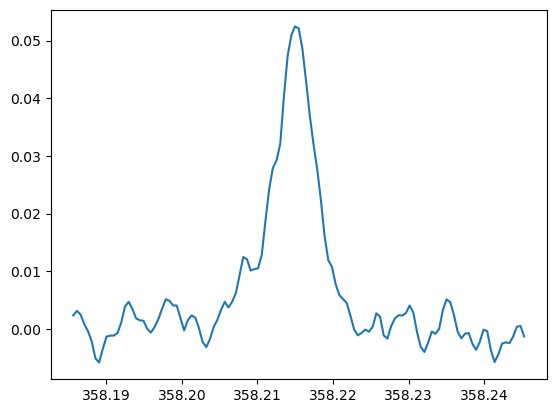

2
SO2


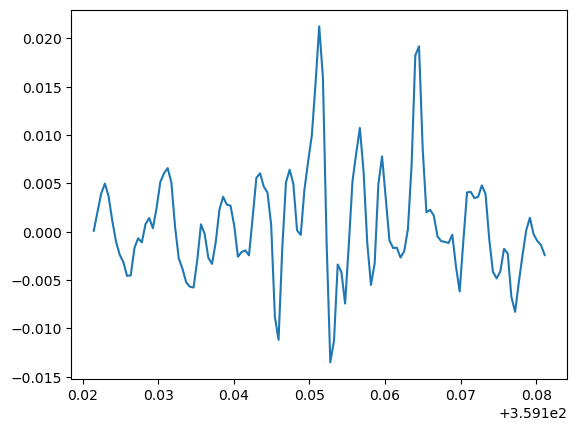

3
SO2


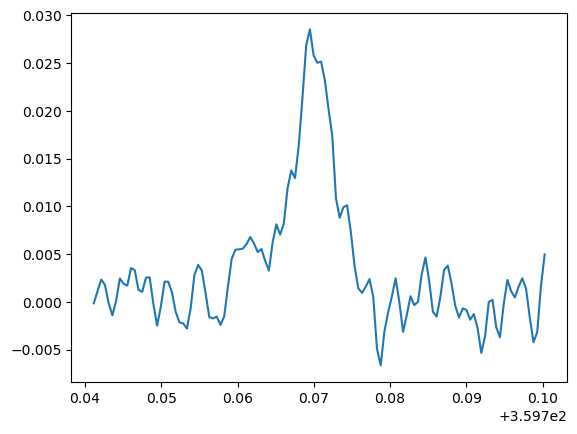

4
34SO2


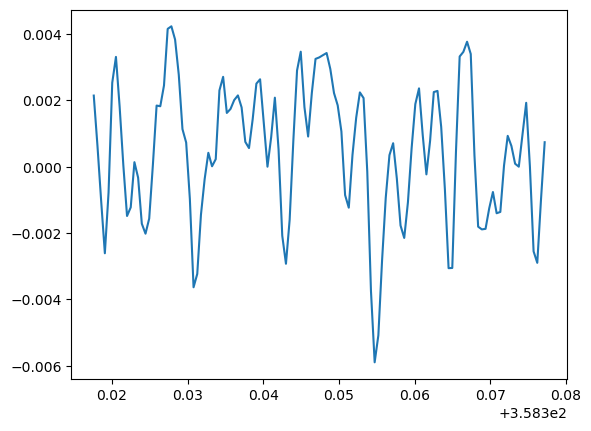

5
34SO2


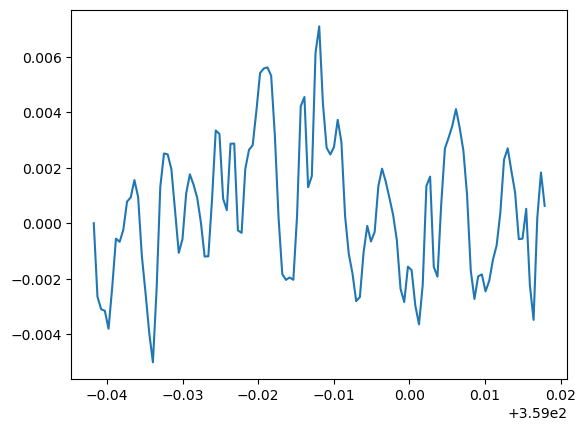

6
CH3OH


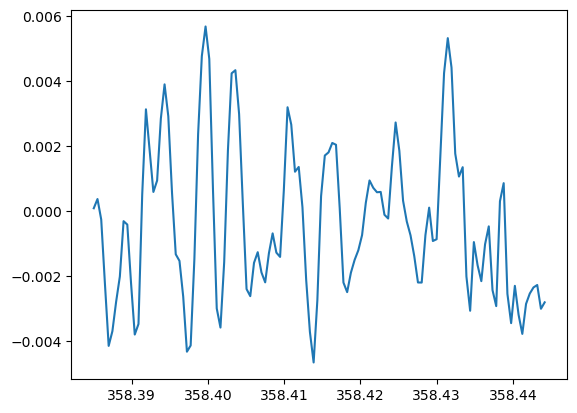

7
CH3OH


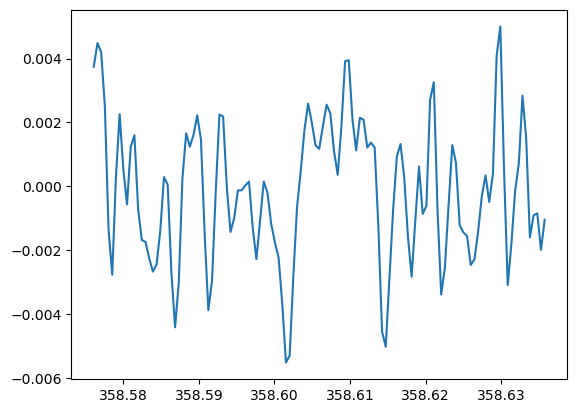

8
CH3OCH3


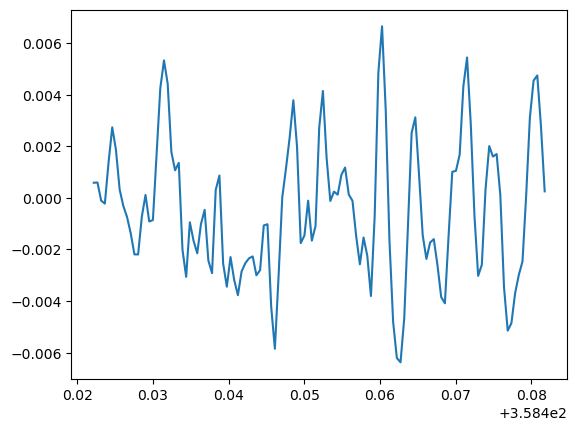

9
H45zeta


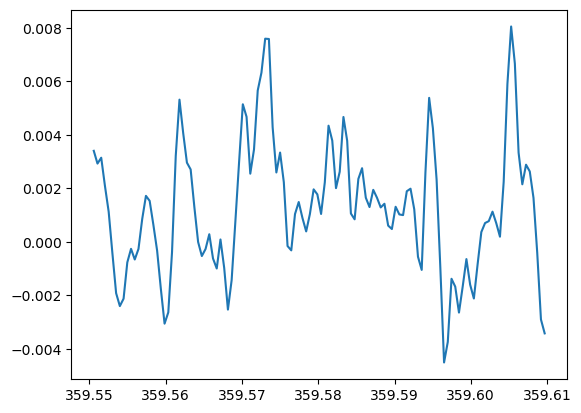

处理文件: spectrum.Lh10.spw0.commonbeam.1arcsec.dat, 源: Lh10, 频率窗口: spw0
  [INFO] 应用速度修正: v = 251.227 km/s
1
34SO2


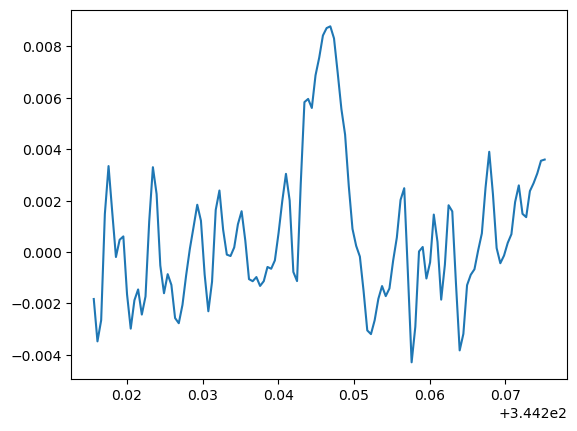

2
34SO2


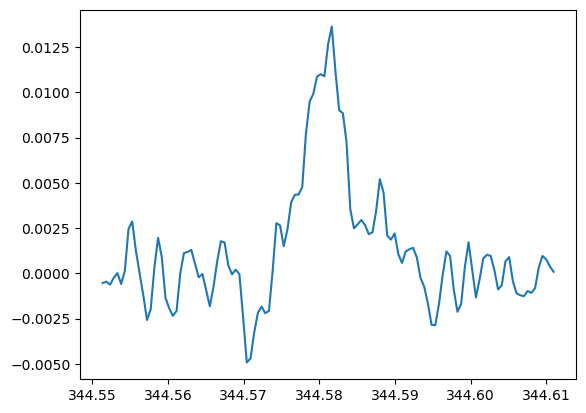

3
34SO2


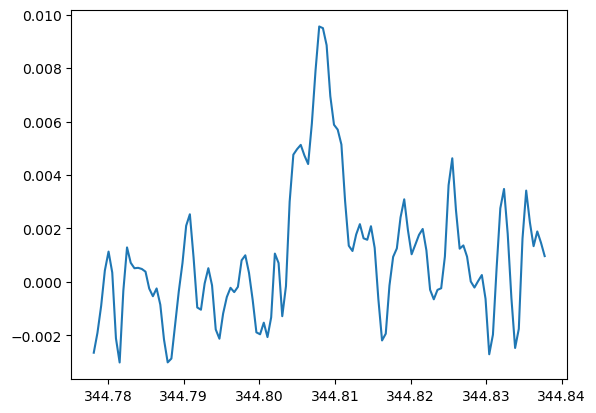

4
34SO2


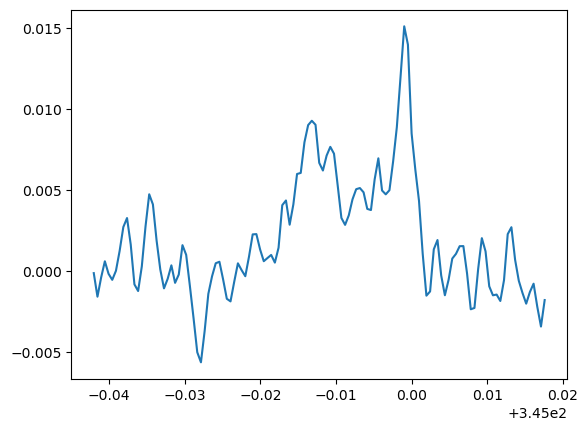

5
34SO2


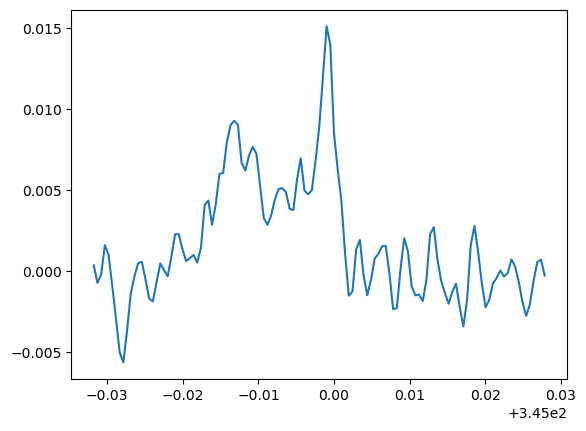

6
SO


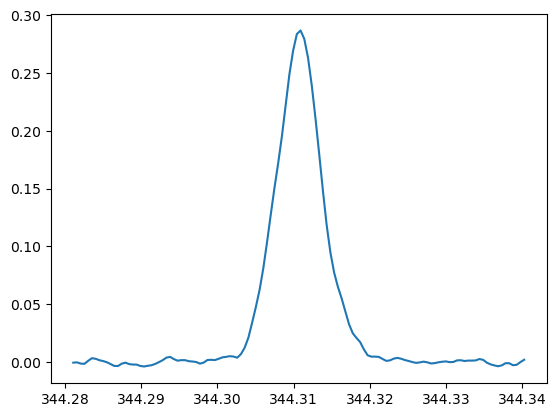

7
CH3OH


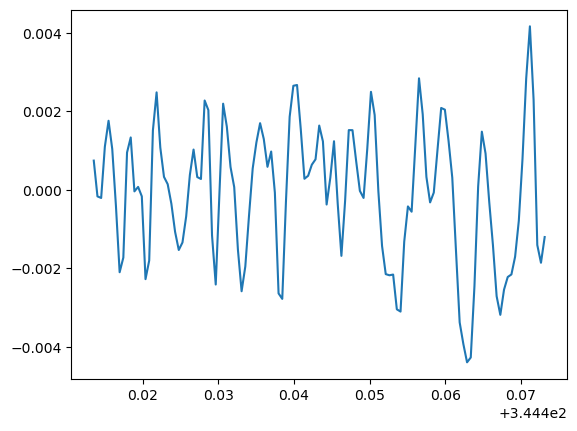

8
CH3OCH3


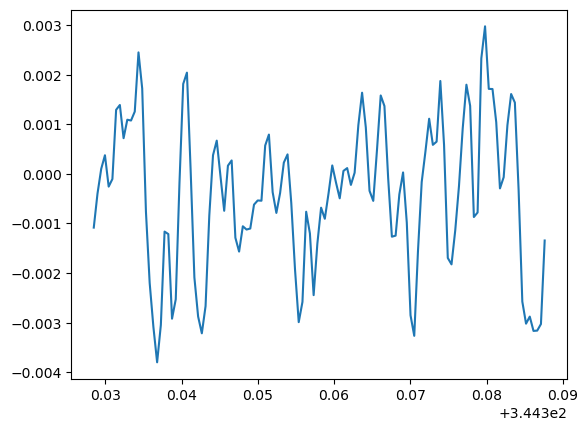

9
CH3OCH3


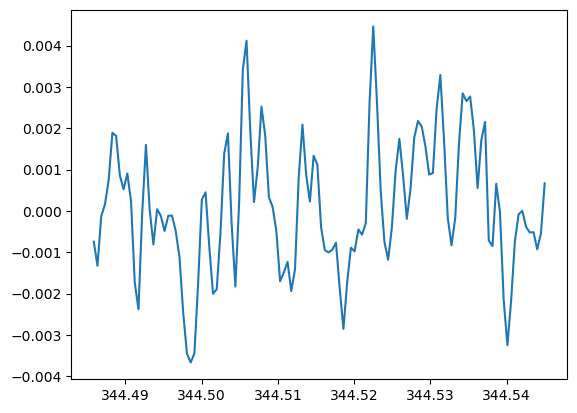

10
t-HCOOH


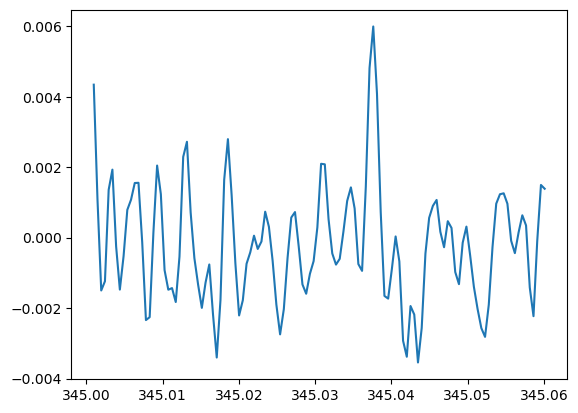

11
HC15N


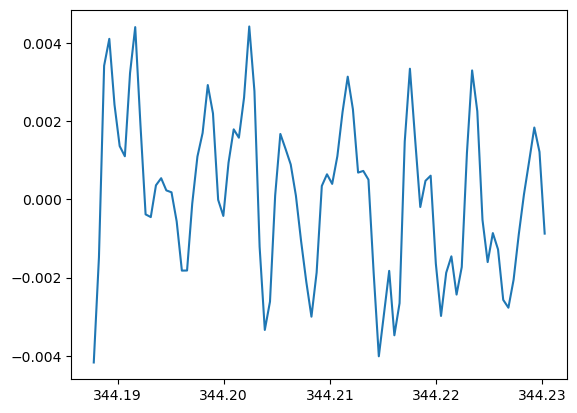

处理文件: spectrum.Lh10.spw1.commonbeam.1arcsec.dat, 源: Lh10, 频率窗口: spw1
  [INFO] 应用速度修正: v = 251.227 km/s
1
SO2


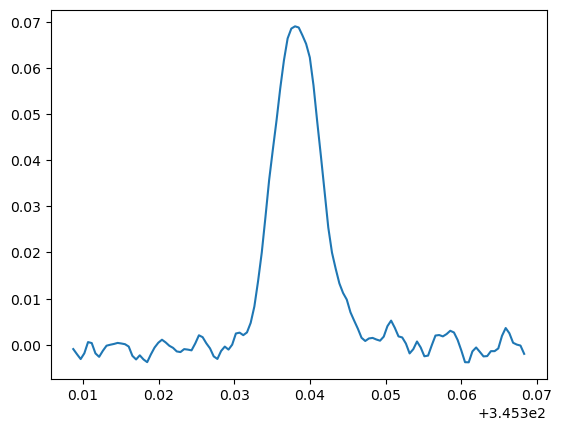

2
SO2


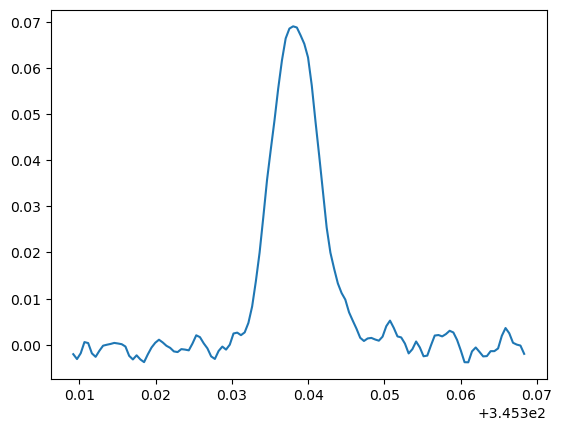

3
SO2


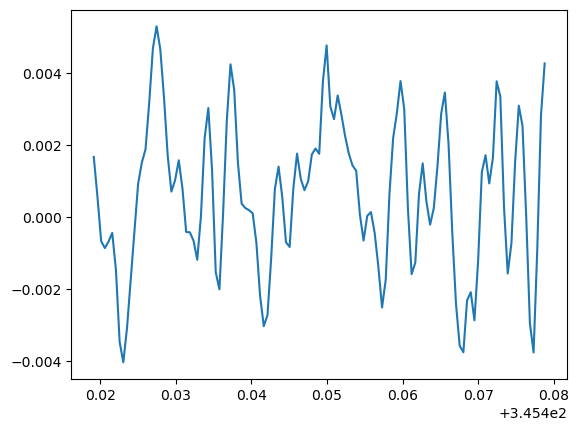

4
34SO2


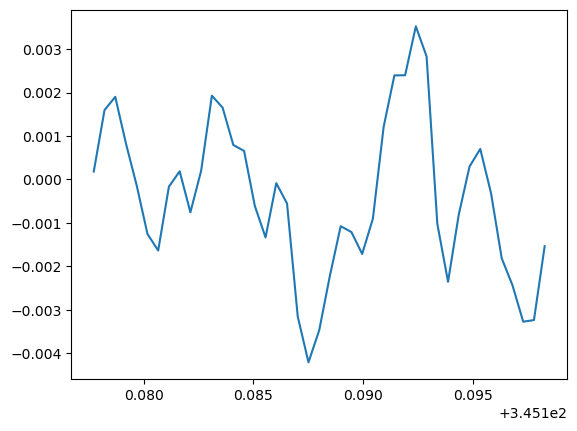

5
34SO2


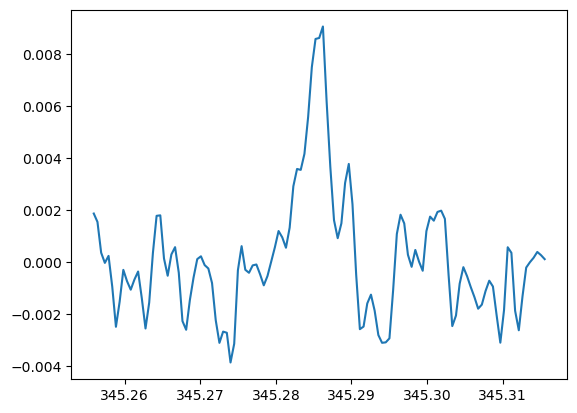

6
34SO2


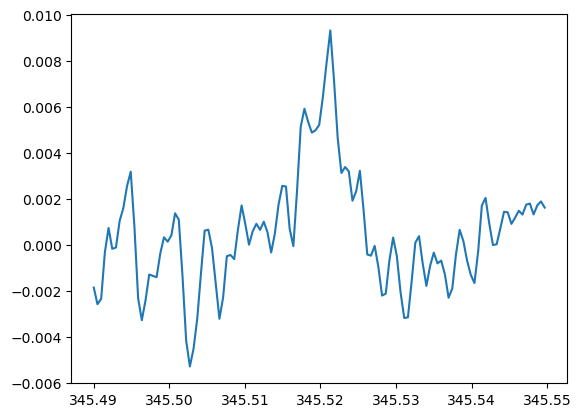

7
34SO2


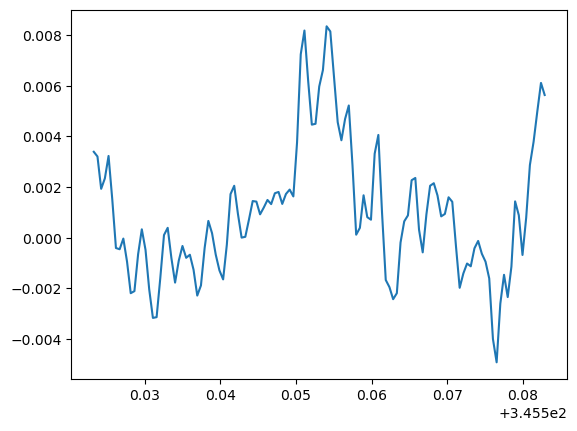

8
34SO2


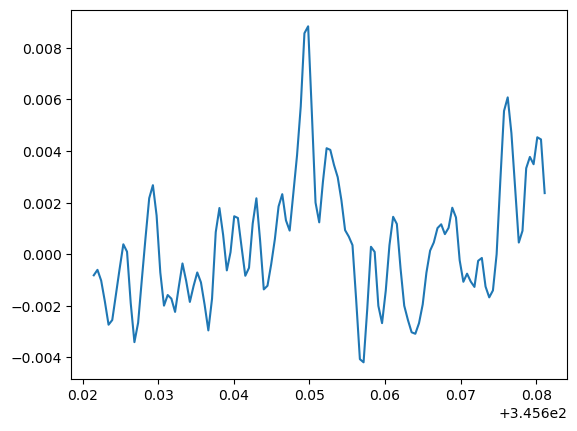

9
34SO2


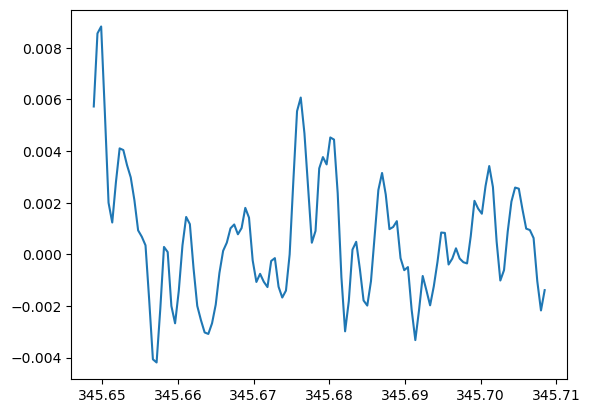

10
34SO2


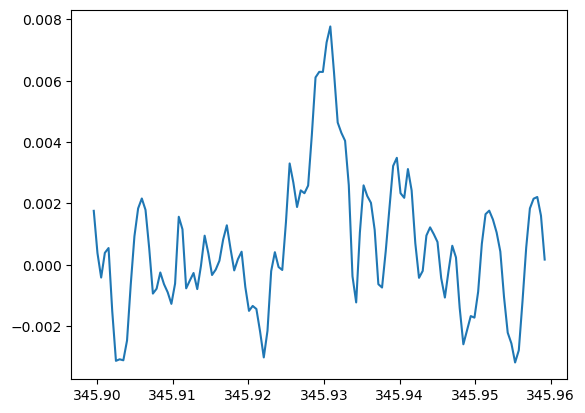

11
CO


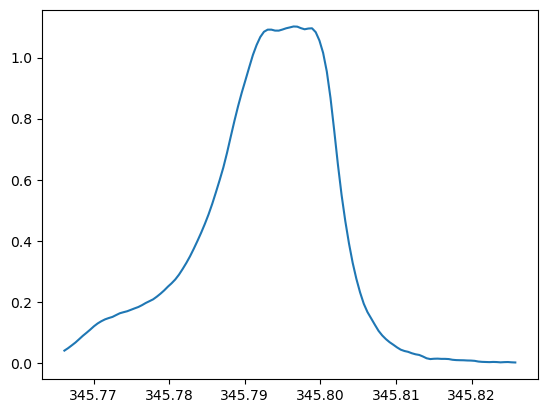

12
CH3OH


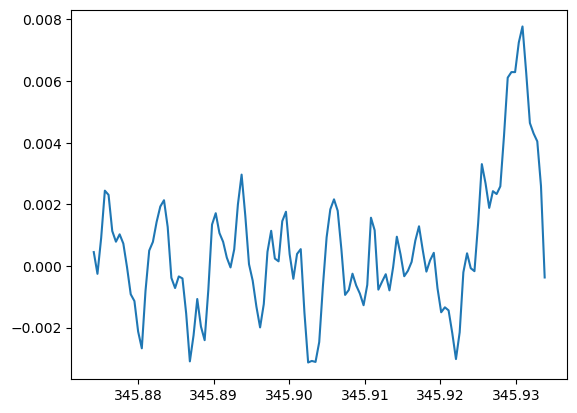

13
CH3OH


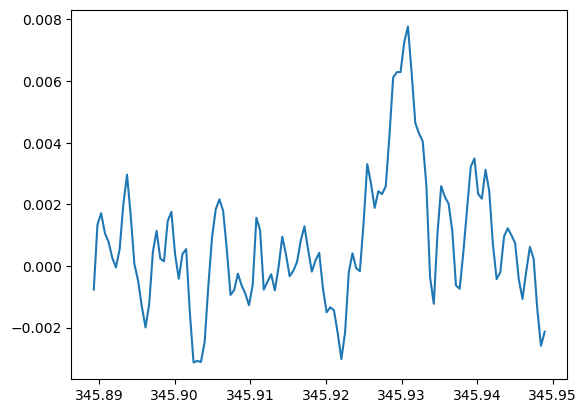

14
HC3N


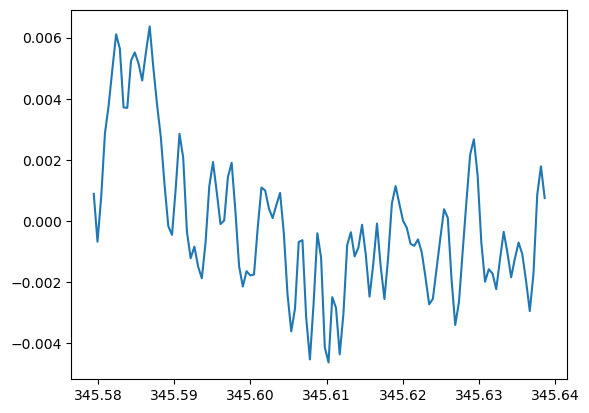

15
33SO2


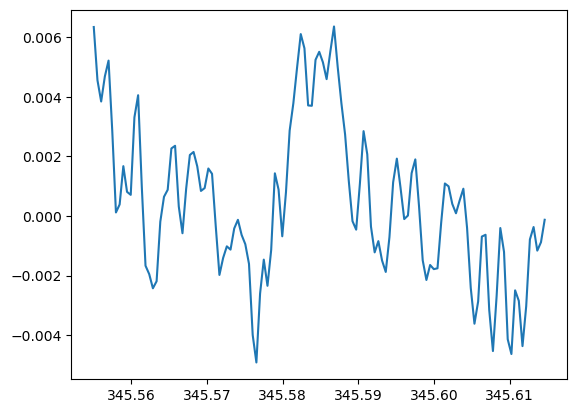

16
CH3OCHO???


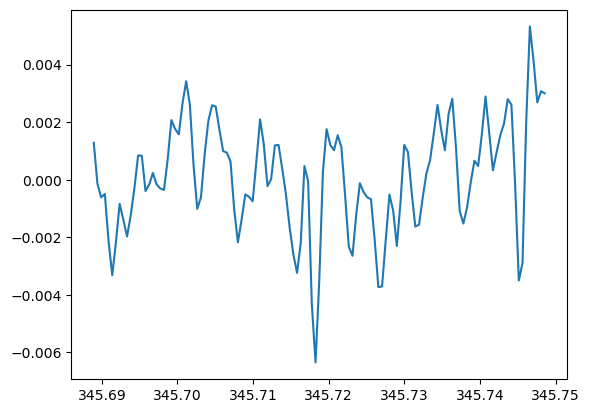

处理文件: spectrum.Lh10.spw2.commonbeam.1arcsec.dat, 源: Lh10, 频率窗口: spw2
  [INFO] 应用速度修正: v = 251.227 km/s
1
SO2


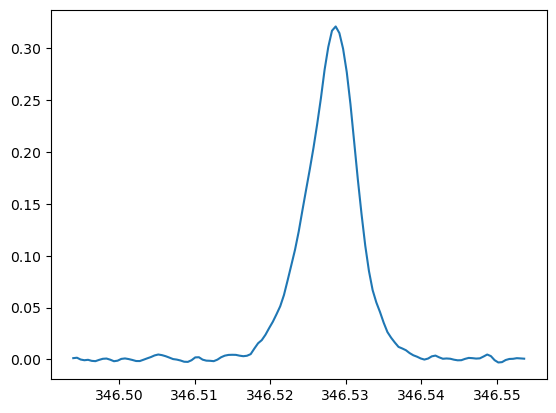

2
SO2


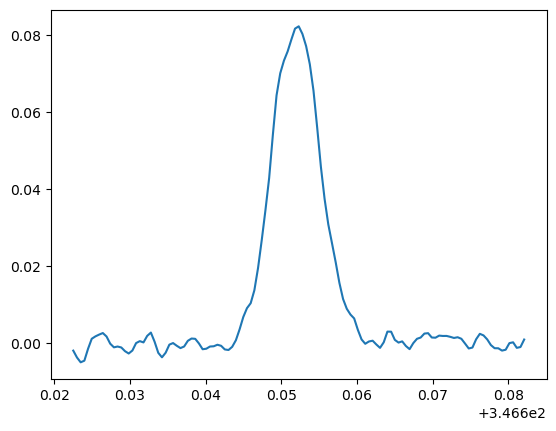

3
SO


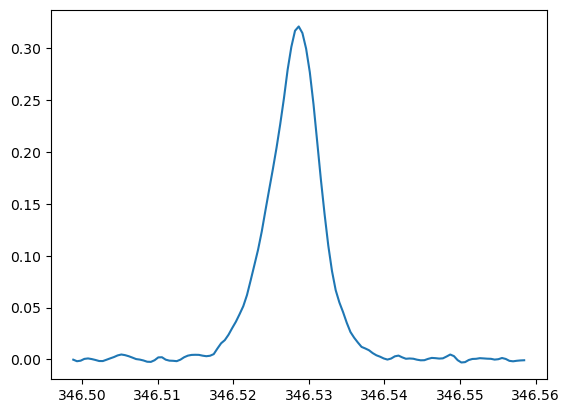

4
SO+


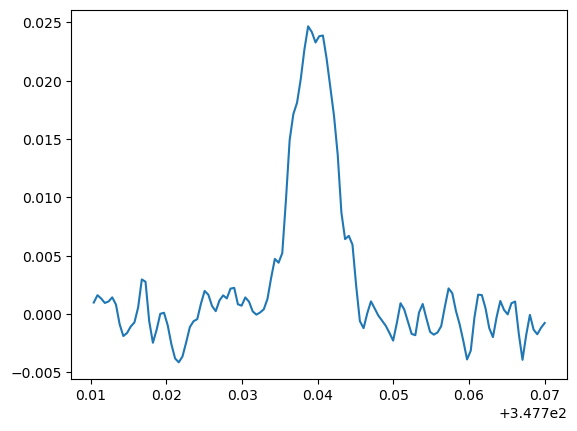

5
SiO


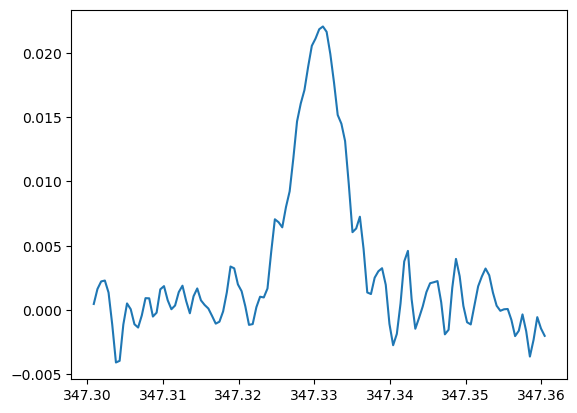

6
H13CO+


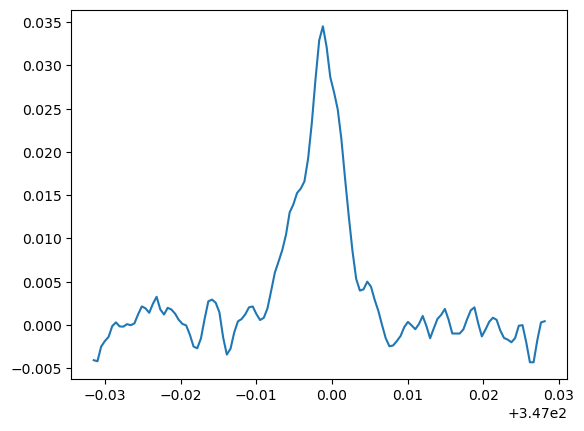

7
CH3OH


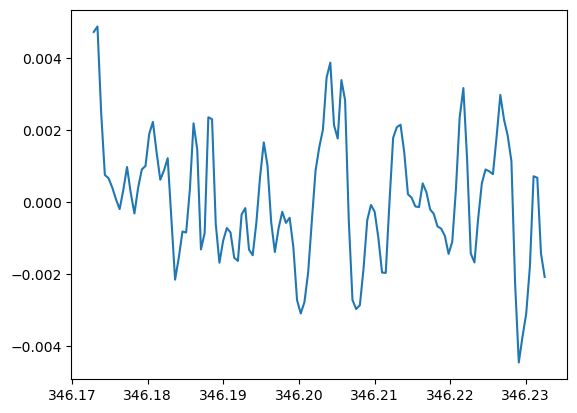

8
t-HCOOH


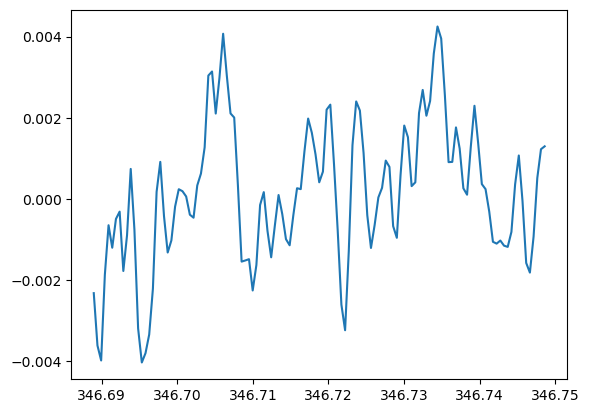

9
H37gamma


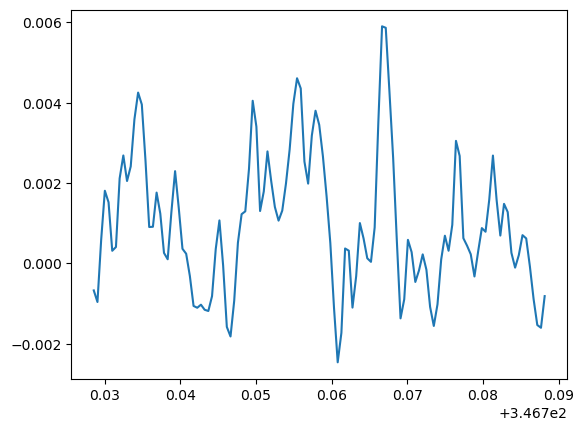

10
33SO2


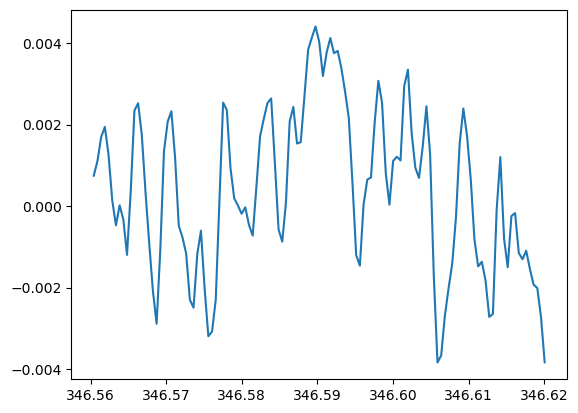

11
NS???


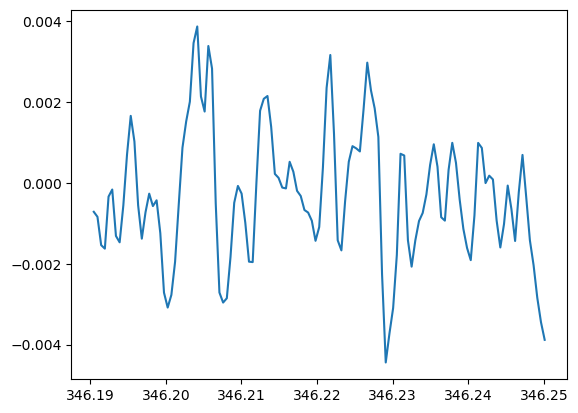

12
SO2_v2=1???


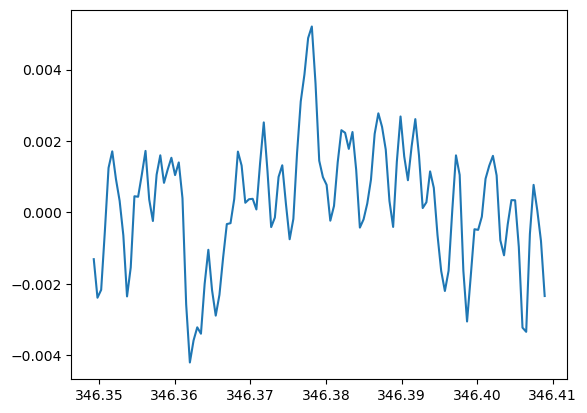

13
13CH3OH???


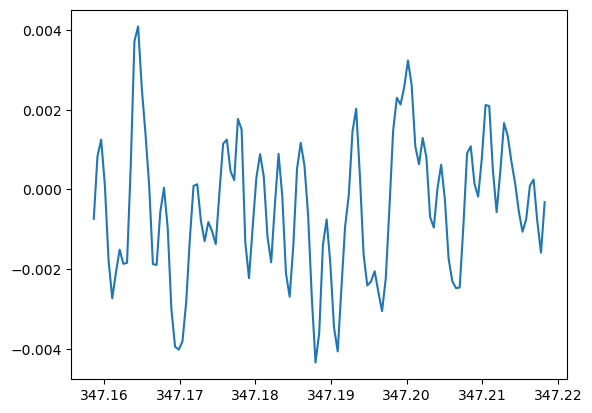

处理文件: spectrum.Lh10.spw3.commonbeam.1arcsec.dat, 源: Lh10, 频率窗口: spw3
  [INFO] 应用速度修正: v = 251.227 km/s
1
SO2


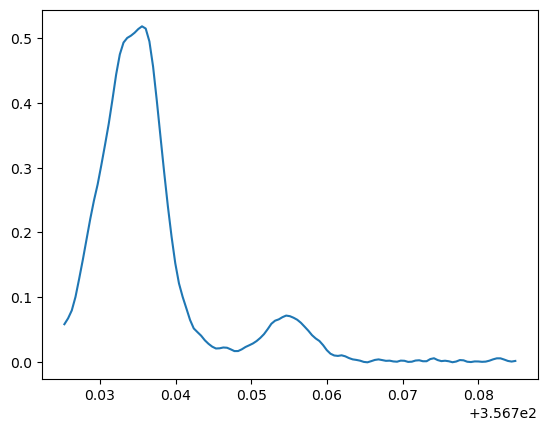

2
SO2


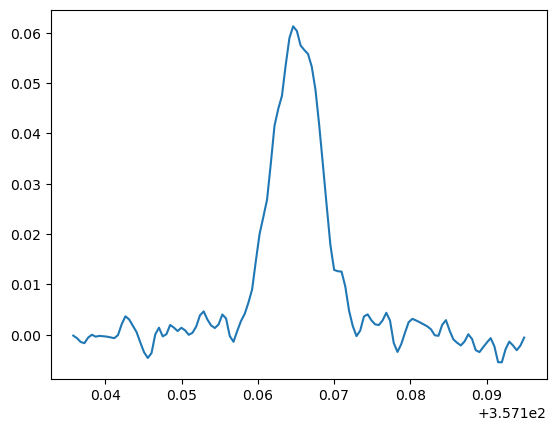

3
SO2


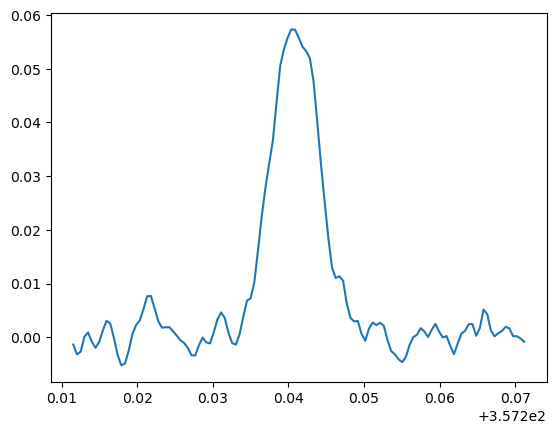

4
SO2


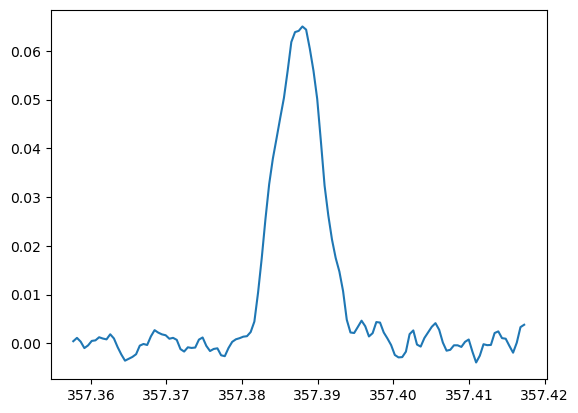

5
SO2


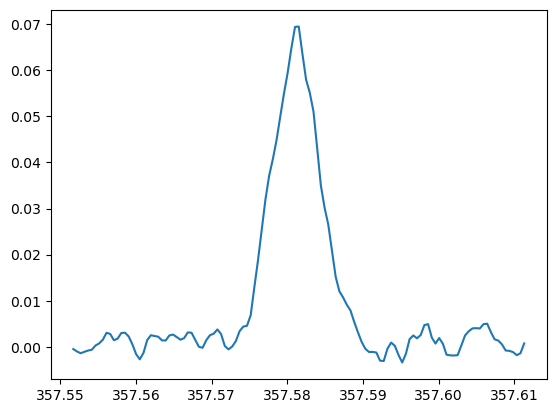

6
SO2


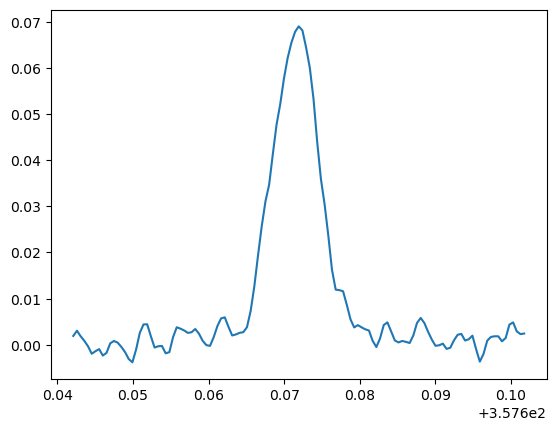

7
SO2


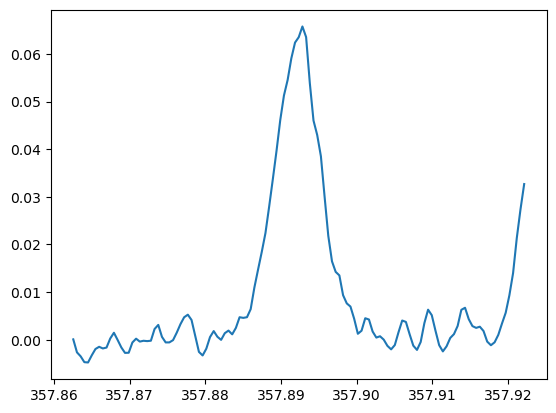

8
SO2


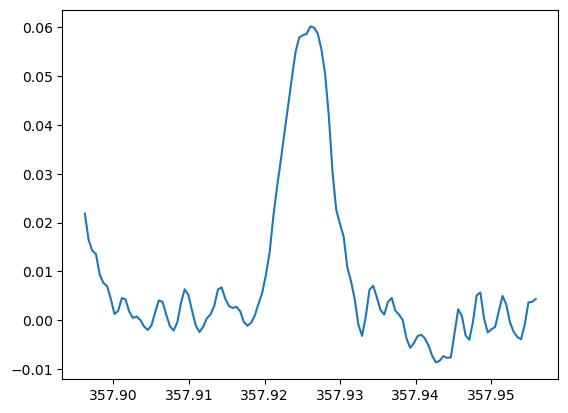

9
SO2


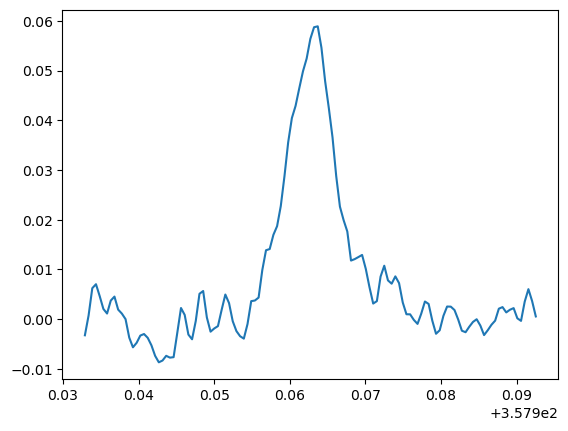

10
SO2


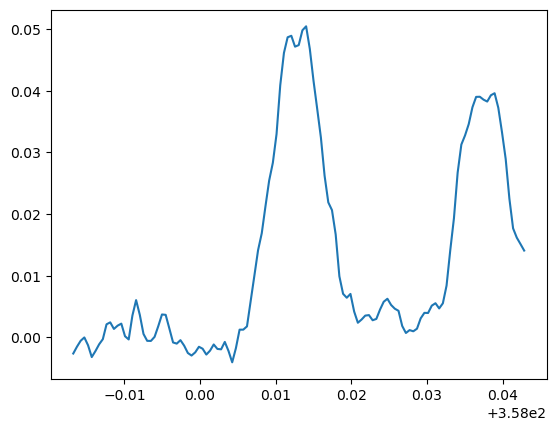

11
SO2


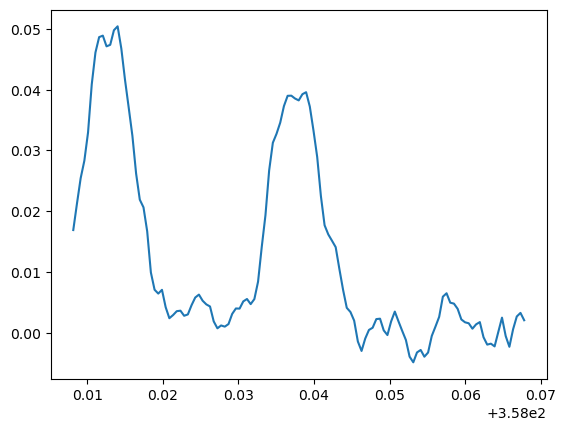

12
SO2


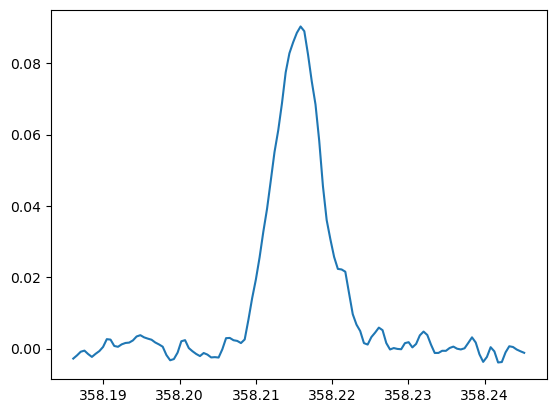

13
34SO2


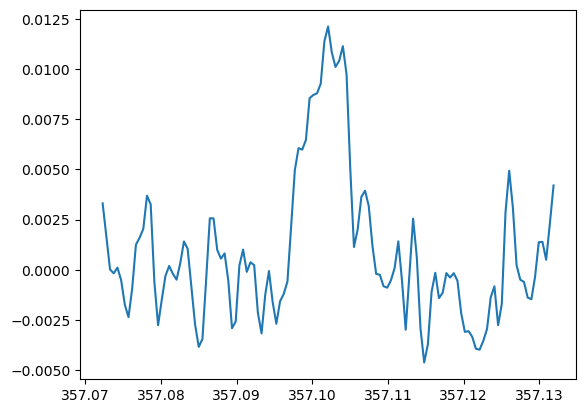

14
34SO2


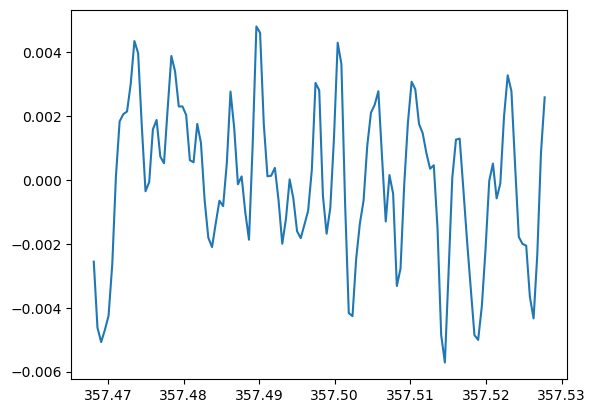

15
34SO2


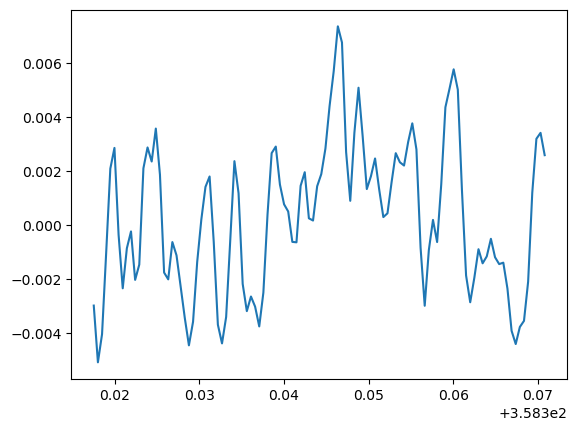

16
HCO+


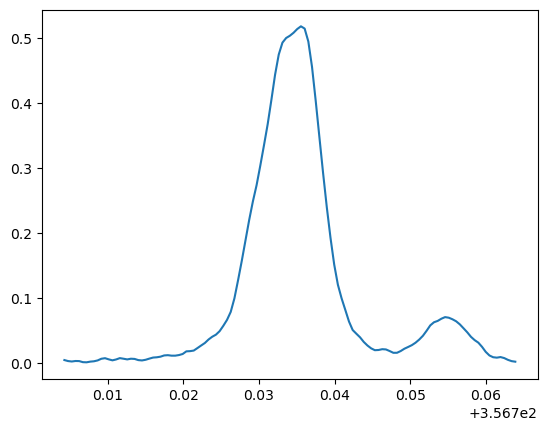

17
CH3OCH3


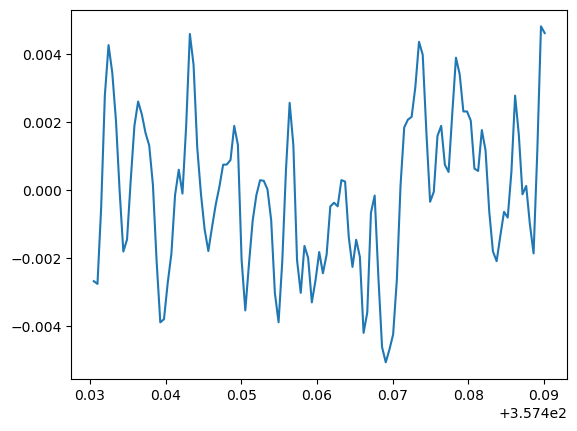

18
H40delta


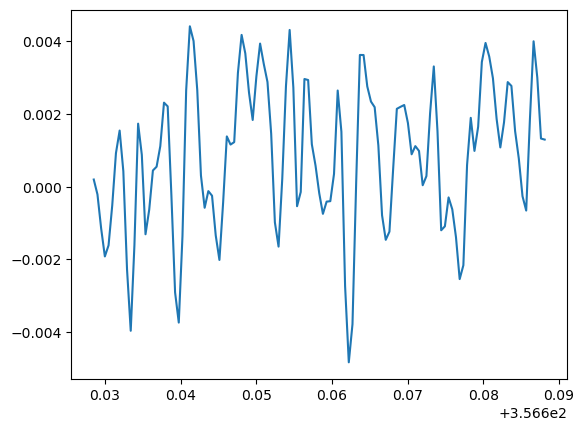

处理文件: spectrum.Lh10.spw4.commonbeam.1arcsec.dat, 源: Lh10, 频率窗口: spw4
  [INFO] 应用速度修正: v = 251.227 km/s
1
SO2


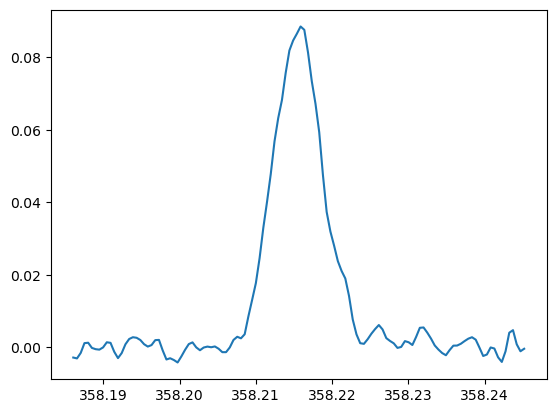

2
SO2


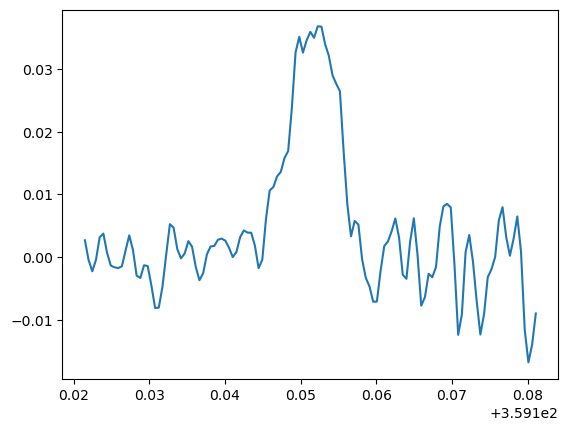

3
SO2


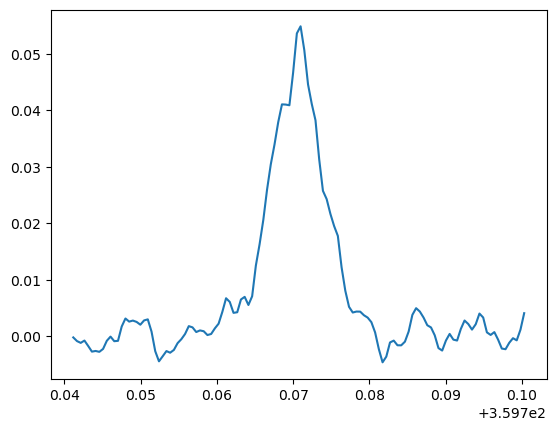

4
34SO2


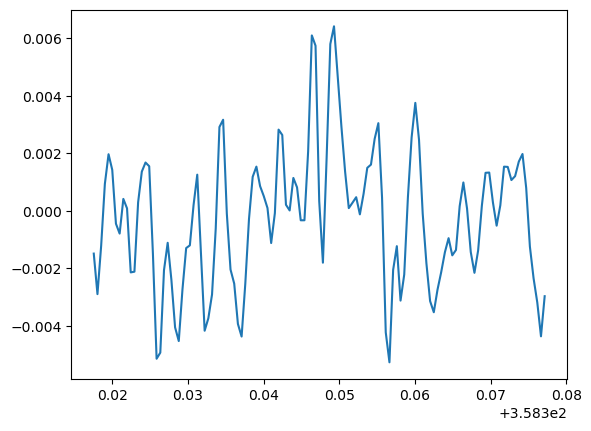

5
34SO2


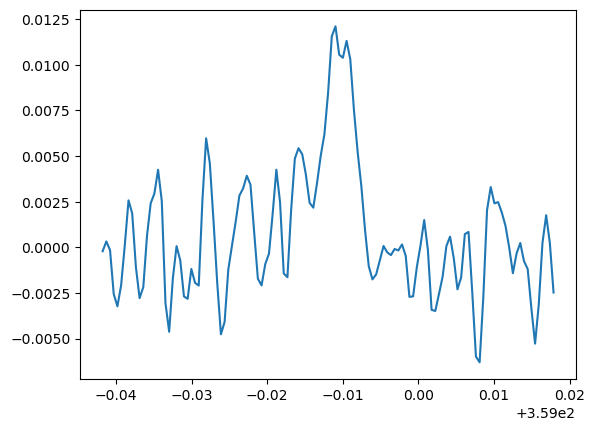

6
CH3OH


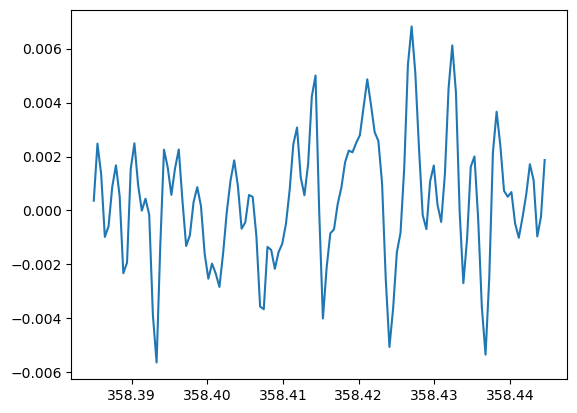

7
CH3OH


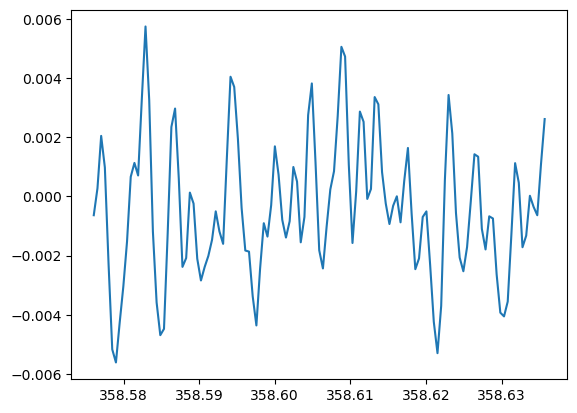

8
CH3OCH3


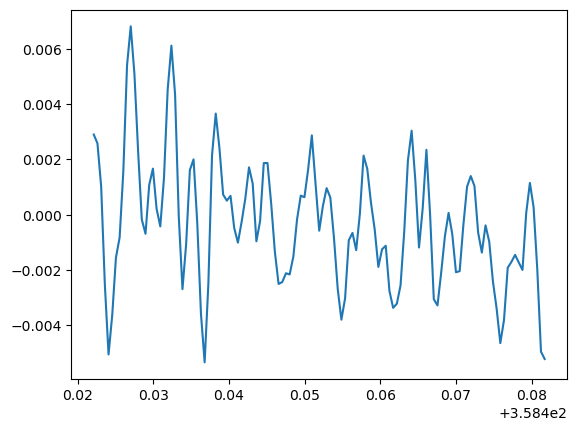

9
H45zeta


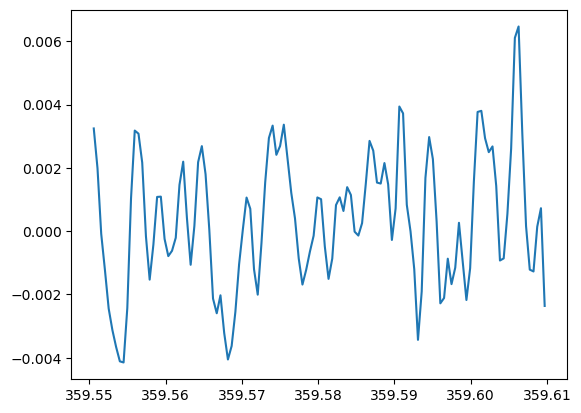

总共提取了 201 个谱线样本


In [49]:
if __name__ == "__main__":
    # 数据目录和谱线列表
    data_dir = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\manysource"
    line_file = "C:\\Users\\zyx\\Desktop\\Spectral with Machine Learning\\data\\linelist_with_mark.txt"
    
    # 定义各源的速度修正值 (km/s)
    velocity_dict = {
        "Lh07": 239.5157166,
        "Lh09": 235.751358,  
        "Lh10": 251.2273865,  
        # 添加更多源和对应的速度...
    }
    
    # 创建多源数据集
    dataset = MultiSourceSpectrumDataset(
        data_dir=data_dir,
        line_file=line_file,
        velocity_dict=velocity_dict,
        target_len=256,
        normalize=True
    )
    

In [34]:
print("=== 所有样本的静止频率 ===")

# 创建列表存储所有样本的频率和源信息
sample_info_list = []

for i in range(len(dataset)):
    source_name, spw, line_name = dataset.get_source_info(i)
    
    # 获取静止频率
    if line_name in dataset.line_name_to_index:
        line_idx = dataset.line_name_to_index[line_name]
        rest_freq = dataset.line_rest[line_idx]
        
        sample_info_list.append({
            'index': i,
            'source': source_name,
            'spw': spw,
            'line': line_name,
            'rest_freq': rest_freq
        })
        
        # 打印每个样本的信息
        print(f"样本{i:3d}: {source_name}-{spw}-{line_name:10s}, 静止频率: {rest_freq:.6f}")

# 按频率排序查看
print("\n=== 按静止频率排序 ===")
sorted_samples = sorted(sample_info_list, key=lambda x: x['rest_freq'])

for sample in sorted_samples:
    print(f"频率 {sample['rest_freq']:.6f}: {sample['source']}-{sample['spw']}-{sample['line']} (样本{sample['index']})")

# 找出重复的频率
print("\n=== 找出重复的静止频率 ===")
freq_dict = {}
for sample in sample_info_list:
    freq = sample['rest_freq']
    if freq not in freq_dict:
        freq_dict[freq] = []
    freq_dict[freq].append(sample)

# 只显示重复出现的频率
for freq, samples in sorted(freq_dict.items()):
    if len(samples) > 1:
        print(f"\n静止频率 {freq:.6f} 出现在 {len(samples)} 个样本中:")
        for sample in samples:
            print(f"  - {sample['source']}-{sample['spw']}-{sample['line']}")

=== 所有样本的静止频率 ===
样本  0: Lh07-spw0-34SO2     , 静止频率: 358.987975
样本  1: Lh07-spw0-34SO2     , 静止频率: 358.987975
样本  2: Lh07-spw0-34SO2     , 静止频率: 358.987975
样本  3: Lh07-spw0-34SO2     , 静止频率: 358.987975
样本  4: Lh07-spw0-34SO2     , 静止频率: 358.987975
样本  5: Lh07-spw0-SO        , 静止频率: 346.528481
样本  6: Lh07-spw0-CH3OH     , 静止频率: 358.605799
样本  7: Lh07-spw0-CH3OCH3   , 静止频率: 358.451943
样本  8: Lh07-spw0-CH3OCH3   , 静止频率: 358.451943
样本  9: Lh07-spw0-t-HCOOH   , 静止频率: 346.718858
样本 10: Lh07-spw0-HC15N     , 静止频率: 344.200320
样本 11: Lh07-spw1-SO2       , 静止频率: 359.770682
样本 12: Lh07-spw1-SO2       , 静止频率: 359.770682
样本 13: Lh07-spw1-SO2       , 静止频率: 359.770682
样本 14: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 15: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 16: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 17: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 18: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 19: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 20: Lh07-spw1-34SO2     , 静止频率: 358.987975
样本 21: Lh07-spw1

In [31]:
print("=== 验证每个源的样本数 ===")

for source in ['Lh07', 'Lh09', 'Lh10']:
    # 获取该源所有样本的spw分布
    spw_counts = {}
    for i, info in enumerate(dataset.source_info):
        if info[0] == source:
            spw = info[1]
            spw_counts[spw] = spw_counts.get(spw, 0) + 1
    
    total = sum(spw_counts.values())
    print(f"{source}: 总计 {total} 个样本")
    
    for spw in sorted(spw_counts.keys()):
        print(f"  {spw}: {spw_counts[spw]} 个样本")
    
    # 验证是否等于67
    if total != 67:
        print(f"  注意: {source} 的样本数 {total} 不等于67")

=== 验证每个源的样本数 ===
Lh07: 总计 67 个样本
  spw0: 11 个样本
  spw1: 16 个样本
  spw2: 13 个样本
  spw3: 18 个样本
  spw4: 9 个样本
Lh09: 总计 67 个样本
  spw0: 11 个样本
  spw1: 16 个样本
  spw2: 13 个样本
  spw3: 18 个样本
  spw4: 9 个样本
Lh10: 总计 67 个样本
  spw0: 11 个样本
  spw1: 16 个样本
  spw2: 13 个样本
  spw3: 18 个样本
  spw4: 9 个样本


In [7]:
print(dataset[0])
print(len(dataset))

(tensor([[-0.0866, -0.1704, -0.2541, -0.2535, -0.2446, -0.1851, -0.1146, -0.0765,
         -0.0505, -0.0668, -0.1067, -0.1259, -0.1280, -0.0928, -0.0135,  0.0442,
          0.0652,  0.0641,  0.0060, -0.0515, -0.1067, -0.1558, -0.1500, -0.1437,
         -0.0810, -0.0184, -0.0272, -0.0421, -0.0584, -0.0750,  0.0123,  0.1365,
          0.2225,  0.2879,  0.2716,  0.1904,  0.1237,  0.0734,  0.0481,  0.0638,
          0.0792,  0.0936,  0.1093,  0.1297,  0.1505,  0.1742,  0.1978,  0.2132,
          0.2286,  0.2356,  0.2419,  0.2461,  0.2499,  0.1788,  0.0825, -0.0208,
         -0.1278, -0.2044, -0.2575, -0.3028, -0.3394, -0.3488, -0.3144, -0.2705,
         -0.2038, -0.1472, -0.1288, -0.0949,  0.0612,  0.2144,  0.2522,  0.2899,
          0.1456, -0.0111, -0.0402, -0.0454,  0.0039,  0.0711,  0.0765,  0.0507,
          0.0195, -0.0157, -0.0266, -0.0114, -0.0035, -0.0067, -0.0118, -0.0210,
         -0.0274, -0.0232, -0.0113,  0.0558,  0.1219,  0.1633,  0.2047,  0.1090,
          0.0047, -0.0714, 